# Présentation du projet : 


## Problématique de la ville de Seattle

Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.
Votre mission

## Mission
Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

* Réaliser une courte analyse exploratoire.
* Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

## Conseils
Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes, et erreurs à éviter :

* L’objectif est de te passer des relevés de consommation annuels (attention à la fuite de données), mais rien ne t'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

* Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

* Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.



# Ressources : 

## Les données et leur description :

Adresse des données : https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv

Site source, ville de Seattle : https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m

Site de visualisation des données : http://www.seattle.gov/energybenchmarkingmap/#seattle/2019?layer=energy_star_score&sort=energy_star_score&order=desc&lat=47.61&lng=-122.33&zoom=14

Description des variables globales : 

* data 2015 : https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m
* data 2016 : https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy
* description plus détaillée (sur 2018) : https://www.splitgraph.com/seattle-gov/2018-building-energy-benchmarking-7rac-kyay

Description de variables particulières :
* Energy star score : https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results
* 2010 Census tract : https://www.census.gov/geographies/reference-maps/2010/geo/2010-census-tract-maps.html

## Sur les méthodes stat :


## Sur les outils de programmation : 


# Présentation du notebook : 

##TODO : écrire une petite intro


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "/home/clairegayral/Documents/openclassroom/data/P3/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P3/"

## my .py : 
from P3_preprocess import *
import missing_values_treatment
import duplicates
import univariate_analysis
import multivariate_analysis

from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import KNNImputer
from sklearn import linear_model


# 1. Lecture des données : 
J'ai commencé par ouvrir les deux table avec la bibliothèque pandas : 

In [2]:
df_2015 = pd.read_csv(data_path+"2015-building-energy-benchmarking.csv", 
                          low_memory=False)#, index_col=0)
df_2016 = pd.read_csv(data_path+"2016-building-energy-benchmarking.csv", 
                          low_memory=False)#, index_col=0)

print("In 2015 data :", df_2015.shape[0],
      " buildings and ", df_2015.shape[1],"variables")
print("Total NaNs = ", df_2015.isna().sum().sum(), 
      "(that is ",np.round(100*df_2015.isna().sum().sum()/(
        df_2015.shape[0]*df_2015.shape[1]),2), "%)")
print(" ")
print("In 2016 data :", df_2016.shape[0],
      " buildings and ", df_2016.shape[1],"variables")
print("Total NaNs = ", df_2016.isna().sum().sum(), 
      "(that is ",np.round(100*df_2016.isna().sum().sum()/(
        df_2016.shape[0]*df_2015.shape[1]),2), "%)")

In 2015 data : 3340  buildings and  47 variables
Total NaNs =  26512 (that is  16.89 %)
 
In 2016 data : 3376  buildings and  46 variables
Total NaNs =  19952 (that is  12.57 %)


## Identification des variables communes 

Les deux tables de données n'ont pas les mêmes variables. Certaines variables sont communes. D'autres ont l'air de correspondre d'une table à l'autre mais n'ont pas la même nomenclature. 
C'est le cas de :
* ```Zip Codes``` dans 2015 et ```ZipCode``` dans 2016
* ```Comment``` dans 2015 et ```Comments``` dans 2016

Il y a aussi les variables de localisation, présentes sous forme de pseudo-dictionnaire dans la variable ```Location``` des données 2015, et dans les colonnes ```Address```, ```City```, ```Latitude```, ```Longitude``` et ```State``` des données 2016. Ces variables ne me semblent pas pertinentes pour la suite de l'étude, car il y a une variable catégorielle ```Neighborhood```qui me semble être un proxi largement suffisant, et beaucoup plus simple à manier. 

De la même manière, j'ai choisi de supprimer la varible ```2010 Census Tracts``` de la table de 2015, car c'est une variable de localisation, et elle est très creuse (93.3% de valeurs manquantes)

In [3]:
### rename similar columns in 2015 as in 2016 data
df_2015 = df_2015.rename(columns={"Zip Codes":"ZipCode",
                                 "Comment":"Comments"})
### Location column split to extract longitude and latitude
print(df_2015["Location"][0].split(","))

### remove non-pertinent columns : 
df_2015 = df_2015.drop(["Location", '2010 Census Tracts', 'City Council Districts'], axis=1)
df_2016 = df_2016.drop(['Address', 'City', 'Latitude', 'Longitude', 'State'],axis=1)

["{'latitude': '47.61219025'", " 'longitude': '-122.33799744'", ' \'human_address\': \'{"address": "405 OLIVE WAY"', ' "city": "SEATTLE"', ' "state": "WA"', ' "zip": "98101"}\'}']


In [4]:
tmp2015 = np.sort(df_2015.columns)
tmp2016 = np.sort(df_2016.columns)

tmp2015 = tmp2015[[var not in df_2016.columns.values for var in tmp2015]]
tmp2016 = tmp2016[[var not in df_2015.columns.values for var in tmp2016]]
tmp_both = df_2015.columns.intersection(df_2016.columns)
## affichage que dans 2015 
print("Les variables qui ne sont que dans les données 2015 : ")
for var in tmp2015 : print("\t",var, ": ", 
                           np.round(100*df_2015[var].isna().sum() / df_2015.shape[0],1), "% NaNs" )
## affichage que dans 2016 
print("\nLes variables qui ne sont que dans les données 2016 : ")
for var in tmp2016 : print("\t",var, ": ", 
                           100*np.round(df_2016[var].isna().sum() / df_2016.shape[0],1), "% NaNs" )
## affichage variables communes :
print("\nLes variables communes aux données 2015 et 2016 : ")
for var in tmp_both : 
    percent_nans =100* (df_2015[var].isna().sum() / df_2015.shape[0] 
                    + df_2016[var].isna().sum() / df_2016.shape[0])/2
    print("\t",var,": ", np.round(percent_nans,1), "% NaNs" )


Les variables qui ne sont que dans les données 2015 : 
	 GHGEmissions(MetricTonsCO2e) :  0.3 % NaNs
	 GHGEmissionsIntensity(kgCO2e/ft2) :  0.3 % NaNs
	 OtherFuelUse(kBtu) :  0.3 % NaNs
	 SPD Beats :  0.1 % NaNs
	 Seattle Police Department Micro Community Policing Plan Areas :  0.1 % NaNs

Les variables qui ne sont que dans les données 2016 : 
	 GHGEmissionsIntensity :  0.0 % NaNs
	 TotalGHGEmissions :  0.0 % NaNs

Les variables communes aux données 2015 et 2016 : 
	 OSEBuildingID :  0.0 % NaNs
	 DataYear :  0.0 % NaNs
	 BuildingType :  0.0 % NaNs
	 PrimaryPropertyType :  0.0 % NaNs
	 PropertyName :  0.0 % NaNs
	 TaxParcelIdentificationNumber :  0.0 % NaNs
	 CouncilDistrictCode :  0.0 % NaNs
	 Neighborhood :  0.0 % NaNs
	 YearBuilt :  0.0 % NaNs
	 NumberofBuildings :  0.1 % NaNs
	 NumberofFloors :  0.1 % NaNs
	 PropertyGFATotal :  0.0 % NaNs
	 PropertyGFAParking :  0.0 % NaNs
	 PropertyGFABuilding(s) :  0.0 % NaNs
	 ListOfAllPropertyUseTypes :  2.0 % NaNs
	 LargestPropertyUseType :  2.3

D'autres variables ont l'air d'avoir un lien fort ```GHGEmissions(MetricTonsCO2e)``` et ```TotalGHGEmissions```. Néanmoins, sachant que le taux CO2 est une des deux variables à prédire, il me paraît nécessaire de ne pas les fusionner avant d'avoir vérifier qu'il n'y avait pas un biais entre les deux. D'après [ce site](https://www.epa.gov/ghgemissions/overview-greenhouse-gases) les émissions de CO2 représentent 80% des émissions de gaz à effet de serre (GHG pour "Green House Gases" en anglais). Vérifions s'il est possible de corriger le biais d'avoir une mesure sur tous les GHG sur la table 2016 :


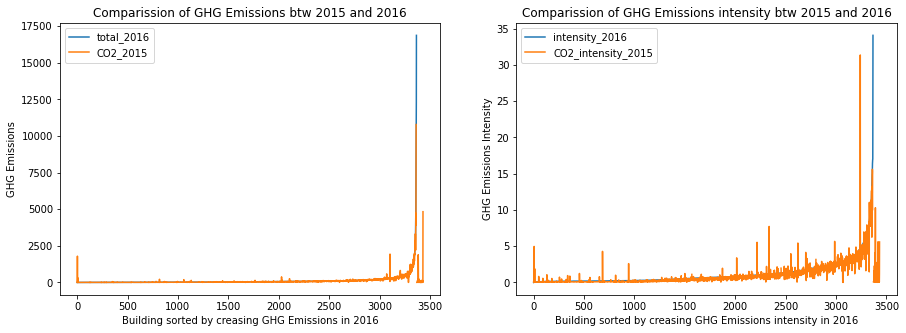

In [5]:
GHG_emissions = pd.merge(
    df_2016[["OSEBuildingID","TotalGHGEmissions","GHGEmissionsIntensity"]], 
    df_2015[["OSEBuildingID", "GHGEmissions(MetricTonsCO2e)","GHGEmissionsIntensity(kgCO2e/ft2)"]], 
    on ="OSEBuildingID" , how = 'outer', suffixes=('', '_2015')).copy()
GHG_emissions = GHG_emissions.rename(columns={"TotalGHGEmissions": "total_2016", 
                                              "GHGEmissionsIntensity":"intensity_2016",
                                              "GHGEmissions(MetricTonsCO2e)":"CO2_2015" ,
                                              "GHGEmissionsIntensity(kgCO2e/ft2)":"CO2_intensity_2015"})
fig = plt.figure(figsize=(15,5))
## plot to compare GHG emission and CO2 emission :
ax = fig.add_subplot(1,2,1)
GHG_emissions = GHG_emissions.sort_values(by = "total_2016", axis = 0 )
ax.plot(range(GHG_emissions.shape[0]), GHG_emissions[["total_2016","CO2_2015"]] )
ax.set_title("Comparission of GHG Emissions btw 2015 and 2016")
ax.set_xlabel("Building sorted by creasing GHG Emissions in 2016")
ax.set_ylabel("GHG Emissions")
ax.legend(["total_2016","CO2_2015"])
## plot to compare intensity of emission
GHG_emissions = GHG_emissions.sort_values(by = "intensity_2016", axis = 0)
ax = fig.add_subplot(1,2,2)
ax.plot(range(GHG_emissions.shape[0]), GHG_emissions[["intensity_2016","CO2_intensity_2015"]] )
ax.set_title("Comparission of GHG Emissions intensity btw 2015 and 2016")
ax.set_xlabel("Building sorted by creasing GHG Emissions intensity in 2016")
ax.set_ylabel("GHG Emissions Intensity")
ax.legend(["intensity_2016","CO2_intensity_2015"])
plt.show()

Il ne semble pas y avoir de biais entre ces deux mesures : je choisis donc de les fusionner, sous le nom commun de respectivement ```CO2_emissions``` et ```CO2_emissions_intensity``` : 

In [6]:
df_2016 = df_2016.rename(columns={"TotalGHGEmissions": "CO2_emissions", 
                                  "GHGEmissionsIntensity":"CO2_emissions_intensity"})
df_2015 = df_2015.rename(columns={"GHGEmissions(MetricTonsCO2e)":"CO2_emissions" ,
                                  "GHGEmissionsIntensity(kgCO2e/ft2)":"CO2_emissions_intensity"})
tmp2015 = np.sort(df_2015.columns)
tmp2016 = np.sort(df_2016.columns)
tmp2015 = tmp2015[[var not in df_2016.columns.values for var in tmp2015]]
tmp2016 = tmp2016[[var not in df_2015.columns.values for var in tmp2016]]
## affichage que dans 2015 
print("Les variables qui ne sont que dans les données 2015 : ")
for var in tmp2015 : print("\t",var, ": ", 
                           np.round(100*df_2015[var].isna().sum() / df_2015.shape[0],1), "% NaNs" )
print(df_2015[tmp2015].describe())

## affichage que dans 2016 
print("\nLes variables qui ne sont que dans les données 2016 : ")
for var in tmp2016 : print("\t",var,  ": ", 
                           np.round(100*df_2016[var].isna().sum() / df_2016.shape[0],1), "% NaNs" )
print(df_2016[tmp2016].head())

Les variables qui ne sont que dans les données 2015 : 
	 OtherFuelUse(kBtu) :  0.3 % NaNs
	 SPD Beats :  0.1 % NaNs
	 Seattle Police Department Micro Community Policing Plan Areas :  0.1 % NaNs
       OtherFuelUse(kBtu)    SPD Beats  \
count        3.330000e+03  3338.000000   
mean         7.142301e+03    24.825644   
std          1.962790e+05    15.006287   
min          0.000000e+00     1.000000   
25%          0.000000e+00    10.000000   
50%          0.000000e+00    26.000000   
75%          0.000000e+00    38.000000   
max          8.269669e+06    51.000000   

       Seattle Police Department Micro Community Policing Plan Areas  
count                                        3338.000000              
mean                                           32.380168              
std                                            19.907567              
min                                             1.000000              
25%                                            14.000000              
5

J'ai supprimé ces variables qui n'apparaissent que dans une des deux tables : 

In [7]:
df_2015 = df_2015.drop(tmp2015, axis = 1)
df_2016 = df_2016.drop(tmp2016, axis = 1)

## Age des bâtiments 
Il me parait plus pertinent de traiter la variable ```YearBuilt``` comme variable quantitative, plutôt que comme variable catégorielle. Pour cela, je déduis 2015 (resp. 2016) à la colonne ```YearBuilt``` pour la remplacer par la nouvelle colonne ```age_of_building```

In [8]:
df_2015.at[:,"age_of_building"] = df_2015["DataYear"] - df_2015["YearBuilt"]
df_2016.at[:,"age_of_building"] = df_2016["DataYear"] - df_2016["YearBuilt"]

df_2015 = df_2015.drop(["YearBuilt","DataYear"], axis = 1)
df_2016 = df_2016.drop(["YearBuilt","DataYear"], axis = 1)

## Changement de type pour ne pas créer de nouvelles valeurs catégorielles :

In [9]:
df_2015["CouncilDistrictCode"] = df_2015["CouncilDistrictCode"].astype("category")
df_2016["CouncilDistrictCode"] = df_2016["CouncilDistrictCode"].astype("category")

## Data merge : 

I decided to merge the 2016 and 2015 dataframes, taking the mean value if the building is in both.

In [10]:
data = pd.merge(df_2016, df_2015, on ="OSEBuildingID" ,
               how = 'outer', suffixes=('', '_2015'))

def my_agg_by_mean(colname):
    if colname[-5:] == "_2015":
        res = data.loc[:,[colname[:-5],colname]]
        data.at[:,colname[:-5]] = res.mean(axis=1)
        data.drop(colname, axis=1, inplace=True)
    return(data)        
    
def my_agg_filling_missing(colname) :
    if colname[-5:] == "_2015":
        res = data.loc[:,[colname[:-5],colname]]
        data.at[:,colname[:-5]] = res[colname[:-5]].fillna(res[colname])
        data.drop(colname, axis=1, inplace=True)
    return(data)
    
float_var = data.loc[:,data.dtypes==float].columns.values
int_var = data.loc[:,data.dtypes==int].columns.values
all_num_var = np.concatenate((float_var,int_var))

for colname in all_num_var:
    data = my_agg_by_mean(colname)
for colname in data.columns :
    data = my_agg_filling_missing(colname)


Changement des types en adéquation avec l'exploration (présentée après) : 

In [11]:
# data[["BuildingType","PrimaryPropertyType","Neighborhood","ComplianceStatus"]] = data[["BuildingType","PrimaryPropertyType","Neighborhood","ComplianceStatus"]].astype("category")
categorical_var_in_data = np.sort(data.columns.intersection(categorical_var))
data[categorical_var_in_data] = data[categorical_var_in_data].astype("category")
# data= data.astype({var :"category" for var in categorical_var_in_data})

numerical_var_in_data = data.columns.intersection(numerical_var)

In [12]:
# ##TODO : je ne sais pas si je garde cette répartition : 
# float_var = data.loc[:,data.dtypes==float].columns.values
# int_var = data.loc[:,data.dtypes==int].columns.values
# all_num_var = np.concatenate((float_var,int_var))

# all_num_var

## Nature des variables : 

Tout d'abord, il est essentiel de savoir quelle variable est pertinente pour mon étude. J'ai utilisé l'histogramme graphique ou le graphique trié de la série de variables, et je l'ai comparé à [la page originale du site Web de Seattle] (https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m) pour déterminer le type de chaque variable. Cela m'a permis de séparer les variables numériques, catégorielles et d'identification : 

*First of all, it is essential to know what variable is relevant for my study. I used the graphical histogram or sorted plot of the variable serie, and I compared that to [the original page on Seattle data website](https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m) to determine what type each variable is. It allowed me to separate numerical, categorical and identification variable :*

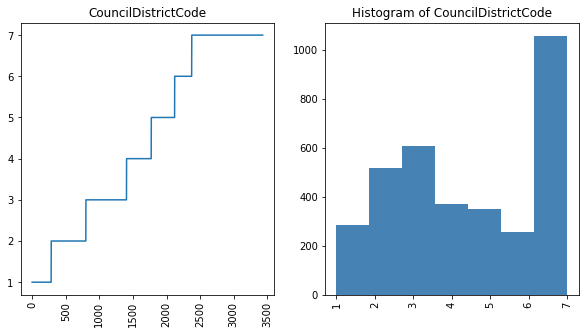

array([1, 2, 3, 4, 5, 6, 7])

In [13]:
var = "CouncilDistrictCode"
univariate_analysis.repartition_and_hist(data,var)
np.unique(data[var])

### Etude grossière des variables descriptives numériques

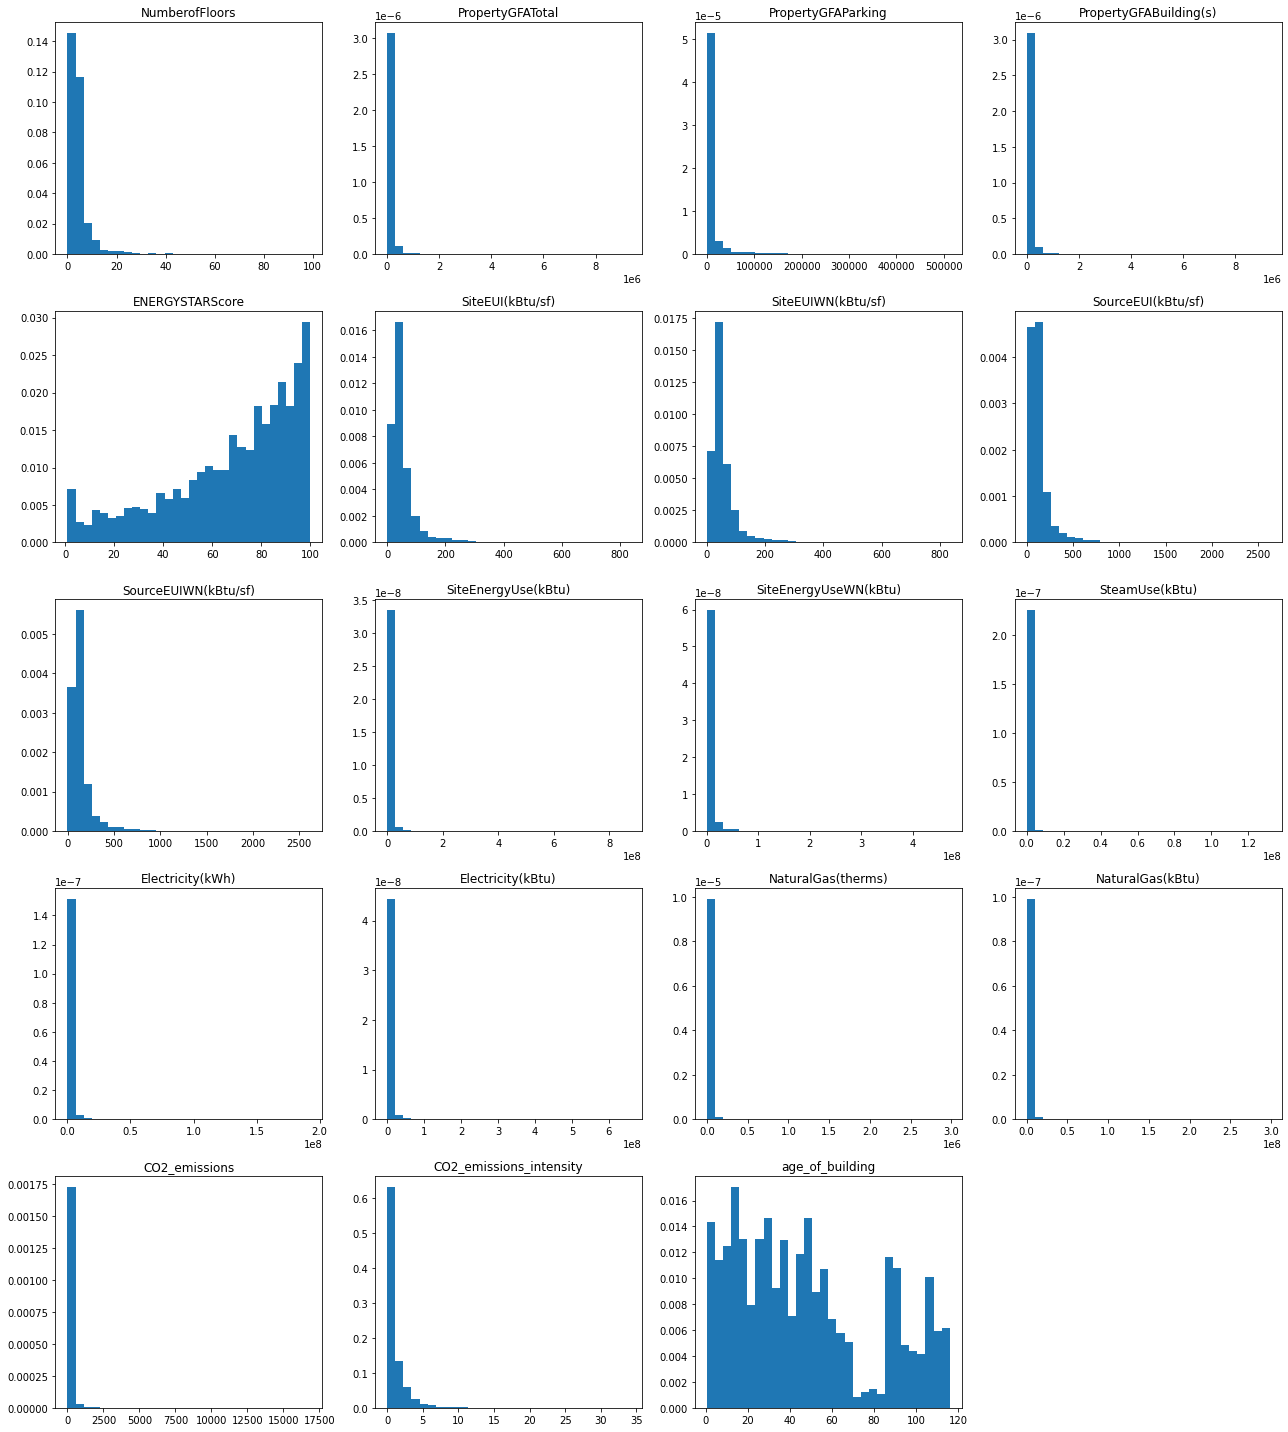

In [14]:
univariate_analysis.plot_multi_hist(data, numerical_var_in_data)

In [15]:
data[numerical_var_in_data].describe()

,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),CO2_emissions,CO2_emissions_intensity,age_of_building
count,3432.000000,3.432000e+03,3432.000000,3.432000e+03,2656.000000,3429.000000,3429.000000,3428.000000,3428.000000,3.429000e+03,3.429000e+03,3.428000e+03,3.428000e+03,3.428000e+03,3.428000e+03,3.428000e+03,3428.000000,3428.000000,3432.000000
mean,4.688228,9.447183e+04,9651.224068,8.482061e+04,68.116717,54.445859,57.489341,133.943174,138.589950,5.398222e+06,5.311222e+06,2.737963e+05,1.087418e+06,3.710342e+06,1.361560e+04,1.361560e+06,119.311982,1.092922,47.145105
std,5.458473,2.172062e+05,32953.838541,2.048840e+05,26.377049,55.895447,57.157732,137.744473,137.275549,2.152855e+07,1.595773e+07,3.795683e+06,4.332754e+06,1.478348e+07,6.729292e+04,6.729292e+06,534.287074,1.769338,33.169116
min,0.000000,1.128500e+04,-1.500000,-8.451000e+03,1.000000,0.000000,0.000000,0.000000,-2.050000,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,0.090000,0.000000,0.500000
25%,2.000000,2.846350e+04,0.000000,2.726825e+04,52.500000,27.850000,29.600000,74.287500,79.500000,9.293272e+05,9.898913e+05,0.000000e+00,1.859820e+05,6.345736e+05,0.000000e+00,0.000000e+00,9.568750,0.150000,18.500000
50%,4.000000,4.419500e+04,0.000000,4.213725e+04,75.500000,38.100001,40.650001,95.900000,101.599999,1.792235e+06,1.940694e+06,0.000000e+00,3.440100e+05,1.173787e+06,3.211758e+03,3.211605e+05,33.842500,0.545000,41.500000
75%,5.000000,9.044875e+04,2890.250000,8.192375e+04,89.625000,60.050000,64.750001,144.150000,149.900002,4.195498e+06,4.402542e+06,0.000000e+00,8.214296e+05,2.802775e+06,1.152796e+04,1.152789e+06,91.890000,1.290000,67.500000
max,99.000000,9.320156e+06,512608.000000,9.320156e+06,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.314066e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,16870.980000,34.090000,116.000000


Il n'a pas l'air d'y avoir de valeurs aberrantes dans ces données, je passe donc ce prétraitement.

### Etude grossière des variables descriptives catégorielles

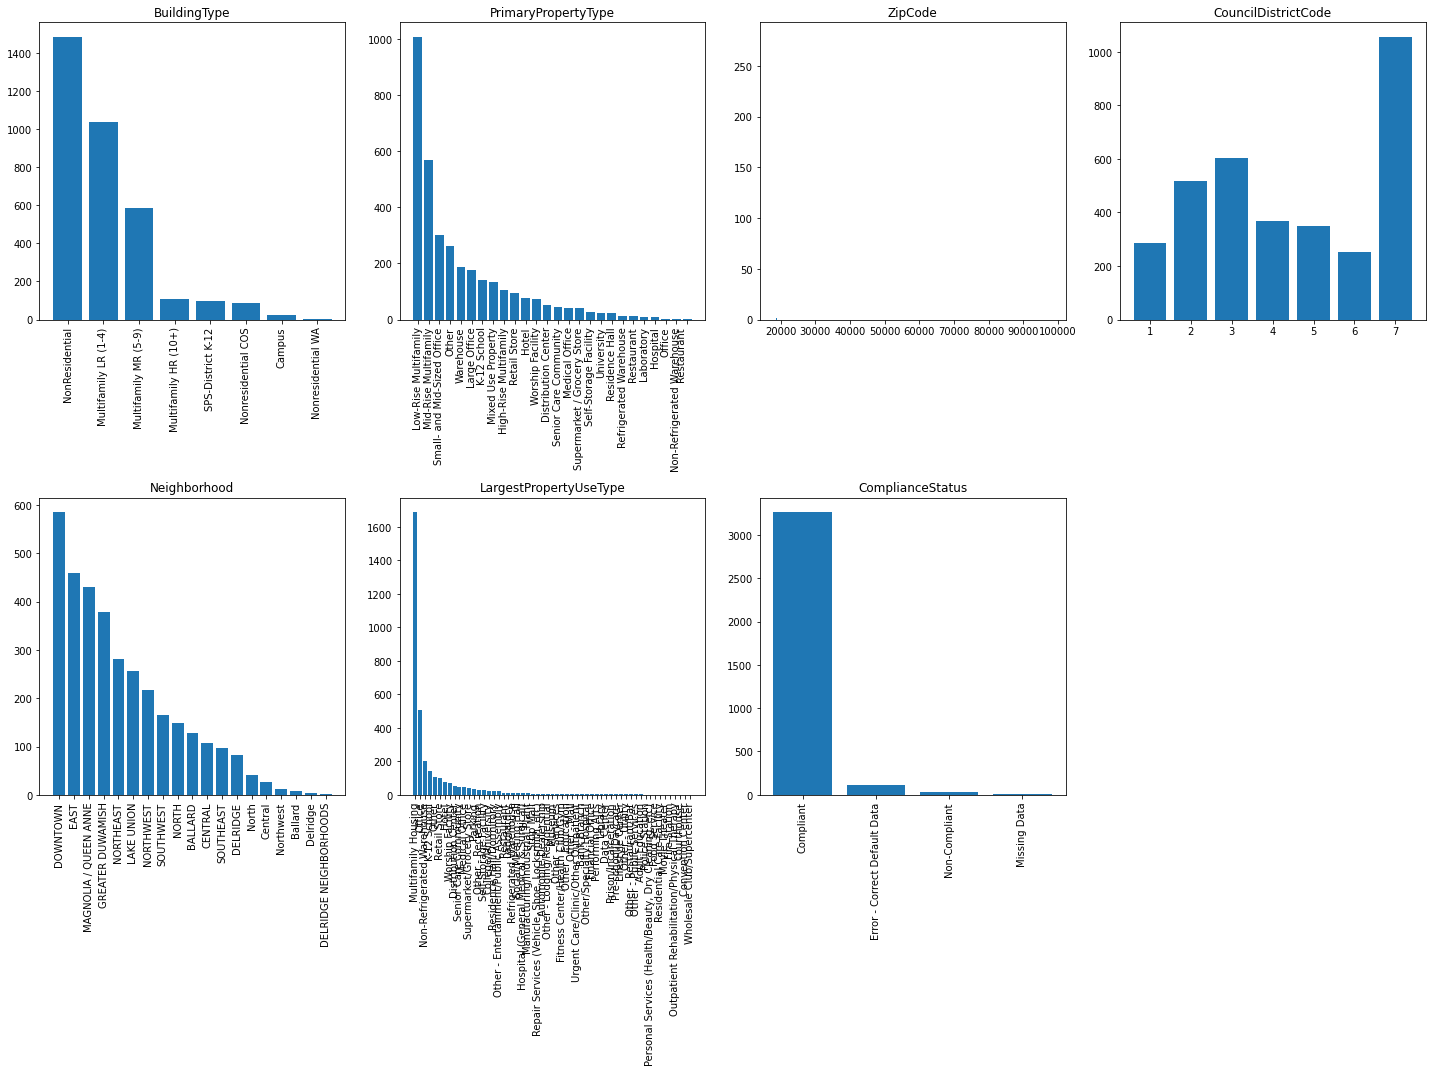

In [16]:
univariate_analysis.plot_multi_hist(data, categorical_var_in_data, figsize=(20,15))

In [17]:
data[categorical_var_in_data].describe()

,BuildingType,ComplianceStatus,CouncilDistrictCode,LargestPropertyUseType,Neighborhood,PrimaryPropertyType,ZipCode
count,3432,3432,3432,3402,3432,3432,3416.0
unique,8,4,7,57,19,26,169.0
top,NonResidential,Compliant,7,Multifamily Housing,DOWNTOWN,Low-Rise Multifamily,58249.5
freq,1488,3267,1057,1689,586,1009,279.0


In [18]:
data.at[data["PrimaryPropertyType"] == "Restaurant\n", "PrimaryPropertyType"] = "Restaurant"
data.at[:,"PrimaryPropertyType"] = data["PrimaryPropertyType"].cat.remove_unused_categories()

# 2. Prétraitements 

## Gestion des types :
Les types semblent donc maintenant corrects (vérifiés avec df.dtypes ou df.info). 

In [19]:
print(data.info())
data[data.columns[data.dtypes=="object"]].head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3432 entries, 0 to 3431
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   OSEBuildingID                    3432 non-null   int64   
 1   BuildingType                     3432 non-null   category
 2   PrimaryPropertyType              3432 non-null   category
 3   PropertyName                     3432 non-null   object  
 4   ZipCode                          3416 non-null   category
 5   TaxParcelIdentificationNumber    3431 non-null   object  
 6   CouncilDistrictCode              3432 non-null   category
 7   Neighborhood                     3432 non-null   category
 8   NumberofBuildings                3431 non-null   float64 
 9   NumberofFloors                   3432 non-null   float64 
 10  PropertyGFATotal                 3432 non-null   float64 
 11  PropertyGFAParking               3432 non-null   float64 
 12  Proper

,PropertyName,TaxParcelIdentificationNumber,ListOfAllPropertyUseTypes,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,DefaultData,Comments,Outlier
0,Mayflower park hotel,0659000030,Hotel,NaN,NaN,NaN,False,NaN,NaN
1,Paramount Hotel,0659000220,"Hotel, Parking, Restaurant",Parking,Restaurant,NaN,False,NaN,NaN


Et j'ai supprimé les variables qui n'étaient ni catégorielles, ni numériques : 

In [20]:
data = data.drop(data.columns[data.dtypes=="object"], axis=1)

##  Suppression colonnes vides :

In [21]:
# var_in_data = data.columns.intersection(all_num_var)
# # num_data = data.loc[:,num_var_in_data]#.set_index(data["OSEBuildingID"])

##
## drop empty columns
##

nan_repartition = data.isna().sum(axis=0)
# nan_threshold = nan_repartition.mean()
nan_threshold = nan_repartition.quantile(0.95)
new_data = data.drop(data.columns[nan_repartition>nan_threshold], axis = 1)

print("I drop variables with less than", 
      data.shape[0]-np.floor(nan_threshold),
      "values")
print("That is more than", np.floor(nan_threshold), "missing values")
print("I have dropped", data.shape[1] - new_data.shape[1], "variables :",
      data.columns[[var not in new_data.columns for var in data.columns]])

data = new_data

I drop variables with less than 2180.0 values
That is more than 1252.0 missing values
I have dropped 2 variables : Index(['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'], dtype='object')


In [22]:
# ## 
# ## drop columns with no variation :
# ##

# data.var()

## Gestion des doublons :

In [23]:
## mise à jour des lists de variables : 
categorical_var_in_data = data.columns.intersection(categorical_var)
num_var_in_data = data.columns.intersection(all_num_var)

## est ce qu'il y a des doublons ?
dict_duplicates = duplicates.get_index_merge_duplicates(data, num_var_in_data, 1.15)
print(dict_duplicates)

{}


## Inférence valeurs manquantes : 

In [24]:
X_var = numerical_var_in_data[[var not in ["CO2_emissions",
                             "SiteEnergyUse(kBtu)","ENERGYSTARScore"] for var in numerical_var_in_data]]
X = data[data.columns.intersection(float_var)]#.set_index(data["OSEBuildingID"])
y = data[["OSEBuildingID", "CO2_emissions","SiteEnergyUse(kBtu)"]]#.reindex(data["OSEBuildingID"])


MSE = 154.083 (+/-37.478) for {'n_neighbors': 1}
MSE = 140.025 (+/-43.065) for {'n_neighbors': 2}
MSE = 135.817 (+/-42.241) for {'n_neighbors': 3}
MSE = 134.423 (+/-41.752) for {'n_neighbors': 4}
MSE = 134.132 (+/-40.908) for {'n_neighbors': 5}
MSE = 133.879 (+/-40.489) for {'n_neighbors': 6}
MSE = 133.916 (+/-40.190) for {'n_neighbors': 7}
MSE = 134.094 (+/-39.865) for {'n_neighbors': 8}
MSE = 134.070 (+/-39.599) for {'n_neighbors': 9}
MSE = 134.276 (+/-39.341) for {'n_neighbors': 10}
MSE = 133.936 (+/-39.643) for {'n_neighbors': 11}
MSE = 133.976 (+/-39.446) for {'n_neighbors': 12}
MSE = 134.141 (+/-39.239) for {'n_neighbors': 13}
MSE = 134.336 (+/-39.093) for {'n_neighbors': 14}


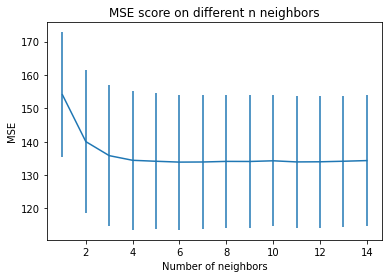

In [25]:
##
## Standardize X : 
##

standardizer = preprocessing.StandardScaler().fit(X)
X_std = standardizer.transform(X)
X_std = pd.DataFrame(X_std, columns= X.columns, index = X.index)

# ##
# ## Set the best number of neighbors
# ##

my_meth = KNNImputer
param_grid = {"n_neighbors" : np.arange(1,15,1)}
cv = 4

# res = missing_values_treatment.launch_my_pseudo_CV(X_std,my_meth,param_grid, cv = cv)
# # Save dictionnary of results : 
# import pickle
# with open(res_path+"set_n_KNN_impute"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

import pickle
with open(res_path+"set_n_KNN_impute"+".pkl", "rb") as f :
        res = pickle.load(f)

fig_name = "set_n_KNN_impute.jpg"
missing_values_treatment.plot_MSE_scores_KNN_impute(res, param_grid, fig_name)

In [26]:
## Impute missing values :
imputer = KNNImputer(n_neighbors=4)
pred_std = imputer.fit_transform(X_std)
pred_std = pd.DataFrame(pred_std, index = X.index, columns = X.columns)

## Inverse-standardize : 
# pred_std = pd.read_csv(res_path+"dataframe_std_KNN_impute.csv",index_col=0)
pred = standardizer.inverse_transform(pred_std)
pred = pd.DataFrame(pred, index = X.index, columns = X.columns)

## uncomment to add predicted values in data : 
data.at[:,pred.columns.values]= pred

## Separation des variables dans le permis de construire : 
En utilisant la description des variables données sur [ce site](https://www.splitgraph.com/seattle-gov/2018-building-energy-benchmarking-7rac-kyay), j'ai classé celles qui me semblaient être dans le permis de construction, et les variables liées à la consommation électrique. Je rappelle que j'ai faire le traitement des variables d'émission de CO2 au préalable.

In [27]:
var_in_building_permit = ['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
                          'CouncilDistrictCode', 'Neighborhood', 'NumberofBuildings',
                          'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
                          'LargestPropertyUseTypeGFA', 'PropertyGFABuilding(s)', 'LargestPropertyUseType',
                          'age_of_building','ComplianceStatus']

CO2_var = ['CO2_emissions','CO2_emissions_intensity']

energy_var = ['SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)',
              'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
              'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
              'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 
              'NaturalGas(therms)','NaturalGas(kBtu)']


# 3. Analyse univariée :

## Données numériques : 

L'histogramme sur la plupart des variables numériques ne permettait pas de distinguer la répartition des données. Je passe en échelle logarithmique les variables où les histogramme étaient peu lisibles, pour voir s'il on arrive mieux à distinguer la distribution avec cette transformation. La première étape pour cela est de retirer les valeurs négatives, qui sont présentes dans certaines variables :

In [28]:
num_data_positive = data[numerical_var_in_data].drop(["ENERGYSTARScore", "age_of_building", "NumberofFloors"], axis = 1)
num_data_positive[num_data_positive<0]= np.nan
num_data_log = np.log(num_data_positive+1)

## create bool dict for log-transfo
dict_var_log_transfo = {}
for var in data.columns : 
    if var in num_data_log.columns.values :
        dict_var_log_transfo[var] = True
    else :
        dict_var_log_transfo[var] = False

Variables de description :


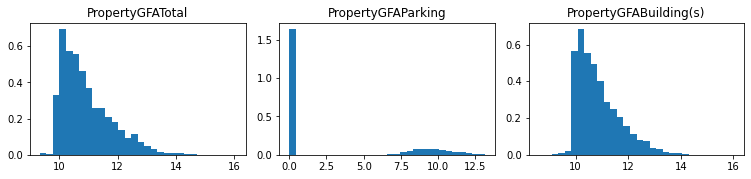

In [29]:
print("Variables de description :")
univariate_analysis.plot_multi_hist(num_data_log, var_in_building_permit, figsize=(14,9))

Pour rappel, "GFA" fait référence à la surface au rez-de-chaussée. Ainsi, le log de la surface au sol des immeubles a l'air de suivre une loi à peu près normale, et une partie importante d'immeuble n'a pas de surface de parking.

Variables de description sans échelle au log :


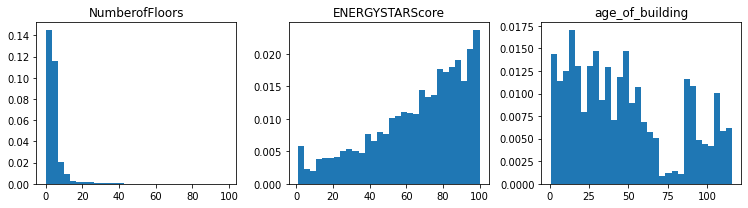

In [30]:
print("Variables de description sans échelle au log :")
univariate_analysis.plot_multi_hist(data, ["ENERGYSTARScore", "age_of_building", "NumberofFloors"], 
                                    figsize=(14,3))

Variables énegétiques :


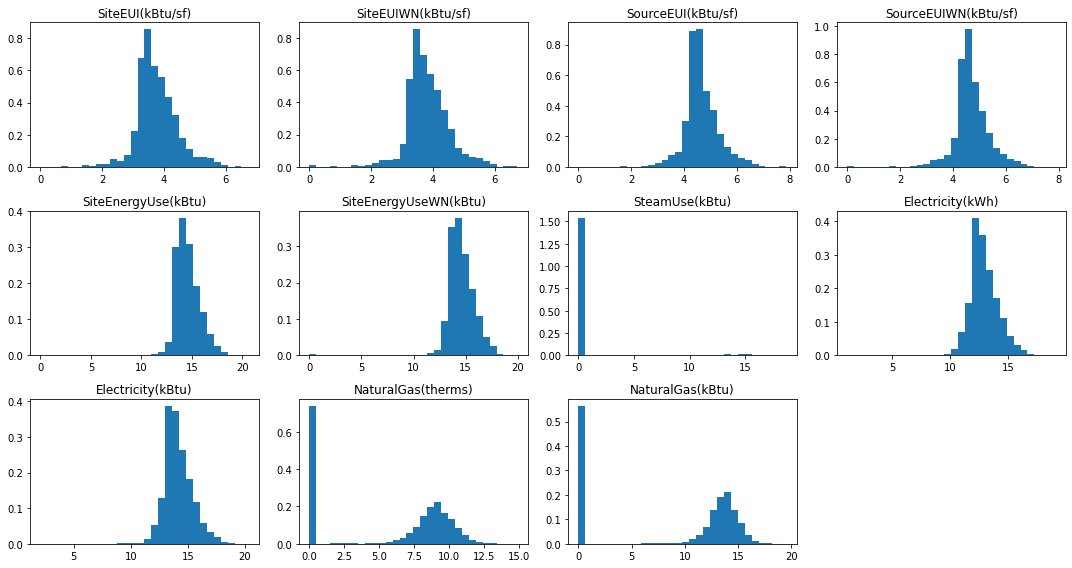

In [31]:
print("Variables énegétiques :")
univariate_analysis.plot_multi_hist(num_data_log, energy_var, figsize=(15,8))

Les variables liées à la consommation électrique ont l'air de suivre des lois normales, bien que la variance a l'air petite, et les queues de distribution assez lourdes. Les variables de consommation de gaz sont la somme d'une distribution de dirac en 0 et d'une loi normale.  

Variable émission CO2


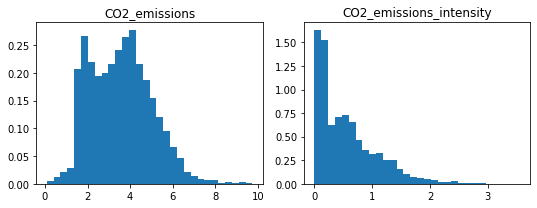

In [32]:
print("Variable émission CO2")
univariate_analysis.plot_multi_hist(num_data_log, CO2_var, figsize=(15,3))

Les variables liées à l'émission de CO2 ont l'air d'être la somme de deux distributions : une première avec une variance et moyenne petites, et une deuxième une peu plus grande (correspondant à la deuxième bosse sur la droite)
<!-- ##TODO : description à compléter -->


### Retrait variables fortement correlées : 

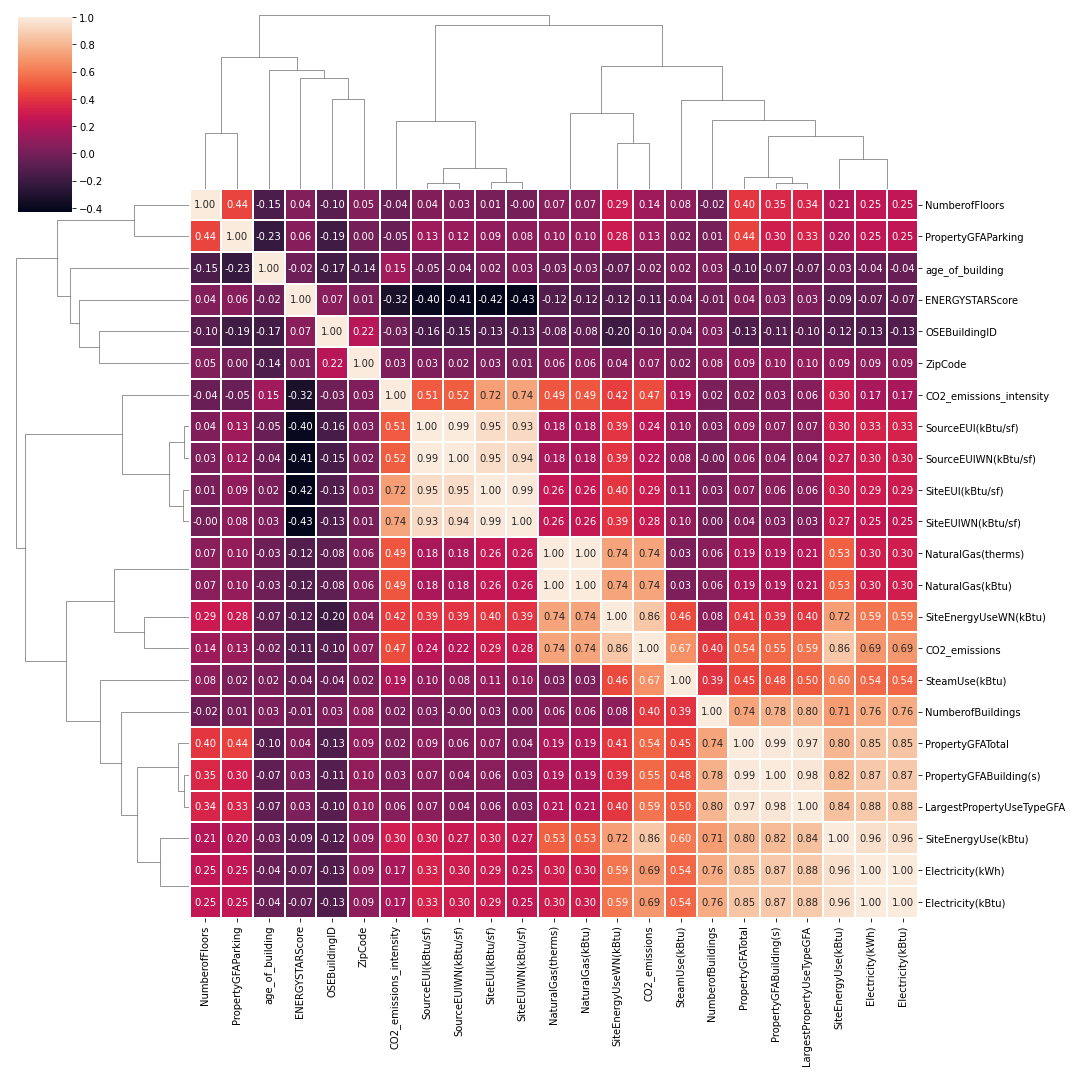

In [33]:
sns.clustermap(data.corr(), annot=True, linewidths=0.1, fmt='.2f', figsize=(15, 15))
plt.show()

On distingue clairement quelques blocs de variables très corrélées : 
* Electricity : 'Electricity(kWh)', 'Electricity(kBtu)', (et 'SiteEnergyUse(kBtu)' que j'ai laissé à part car variable de réponse)
* lui même très fortement corrélé au groupe Ground Floor Area : 'PropertyGFATotal','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA'
* Natural Gas : 'NaturalGas(therms)', 'NaturalGas(kBtu)'
* Energy Use Intensity : 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)'

Je propose donc de regrouper les variables consommation électrique sous la variable "electricity", celles consernant la surface au sol en "ground_floor_area", la consommation de gaz naturel sous "natural_gas" et les variables EUI sous "energy_use_intensity". Les valeurs prise correspondront aux valeurs de la variable la plus corrélée à nos variables de réponse, soit l'émission de CO2 et la consommation d'énergie. 

In [34]:
dict_corr_var = {"electricity":['Electricity(kWh)', 'Electricity(kBtu)'],
        "ground_floor_area":['PropertyGFATotal','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA'],
        "natural_gas":['NaturalGas(therms)', 'NaturalGas(kBtu)'],
        "energy_use_intensity":['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 
                                'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)']}
new_data = data.copy()
for res_var in dict_corr_var.keys() :
    list_of_var = dict_corr_var[res_var]
    corr_matrix = data[np.concatenate((list_of_var, ["CO2_emissions","SiteEnergyUse(kBtu)"]))].corr()
    ## extract the column with max absolute mean of corr with the response variables 
    var_to_keep = corr_matrix.loc[["CO2_emissions","SiteEnergyUse(kBtu)"],list_of_var].abs().mean().idxmax()
    ## drop columns too much correlated : 
    for var in list_of_var :
        if var != var_to_keep : 
            new_data = new_data.drop(var, axis = 1)
data = new_data

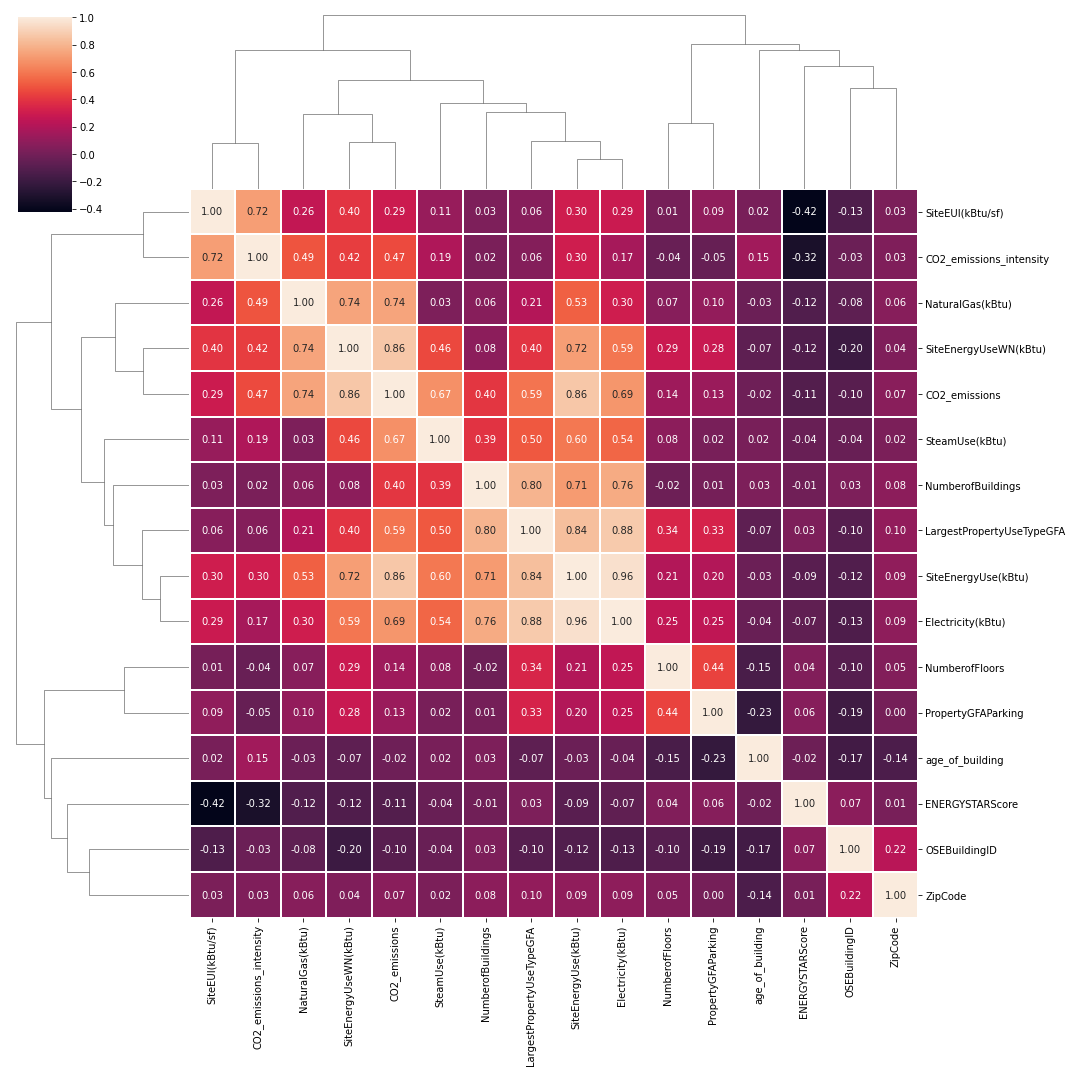

In [35]:
sns.clustermap(data.corr(), annot=True, linewidths=0.1, fmt='.2f', figsize=(15, 15))
plt.show()

In [36]:
num_training_var = data.columns[data.dtypes==float]
num_training_var = num_training_var.intersection(var_in_building_permit)
num_output_var = ["CO2_emissions","SiteEnergyUse(kBtu)"]
num_other_var = np.setdiff1d(data.columns, np.concatenate((num_output_var, var_in_building_permit)))

### Distribution des variables sélectionnées : 
J'ai été confrontée à certaines difficultés pour afficher plusieurs graphes, groupés par 2 verticalement. J'ai utilisé [une solution proposée sur ce forum](https://stackoverflow.com/questions/49054631/fill-matplotlib-subplots-by-column-not-row) dont j'ai copié la fonction ```row_based_idx```. 
J'ai intégré ces fonctions à mon script dédié "univariate_analysis.py"

In [37]:
from univariate_analysis import *

#### Distribution des variables dans le permis de construction : 

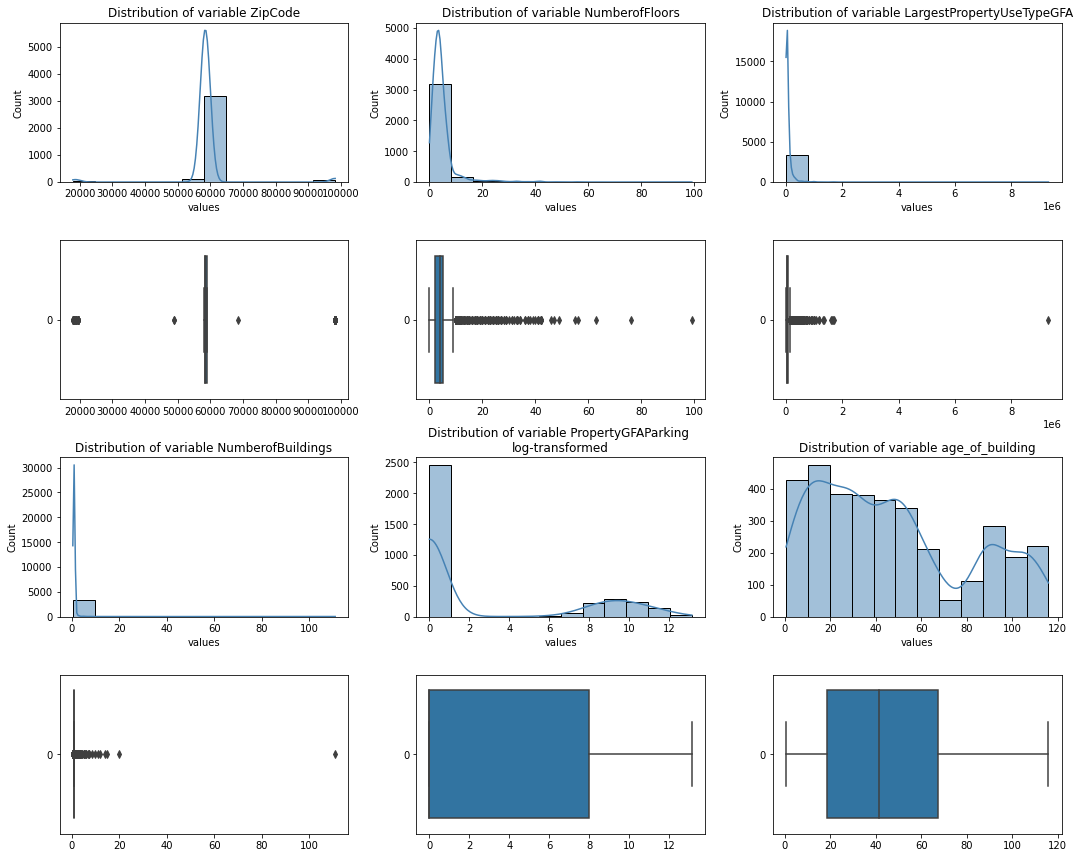

In [38]:
plot_multi_hist_and_boxplot(data, num_training_var,  dict_var_log_transfo, nb_fig_in_line = 3, figsize=(15,12))

##TODO : faire une description de ces graphes

<!-- #### Distribution des variables de sortie :  
plot_multi_hist_and_boxplot(data, num_output_var, nb_fig_in_line = 2, figsize=(12,7))
dict_log = {var: True for var in num_output_var}
plot_multi_hist_and_boxplot(data, num_output_var, dict_log, nb_fig_in_line = 2, figsize=(12,7))
-->

## Données catégorielles 
### Etude descriptive univariée

In [39]:
cat_training_var = data.columns[data.dtypes=="category"].intersection(var_in_building_permit)

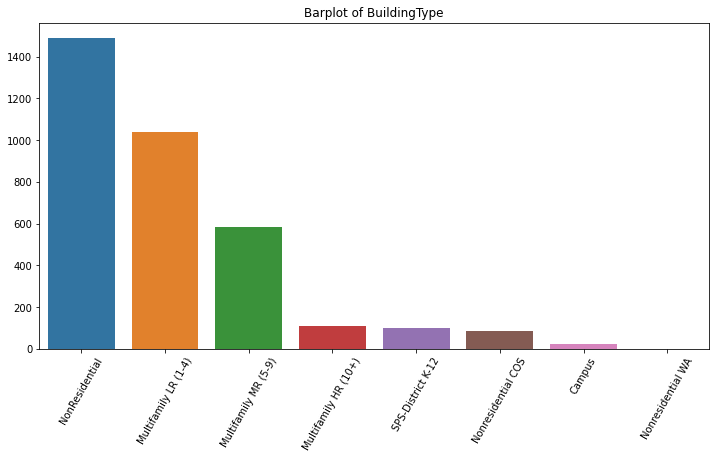

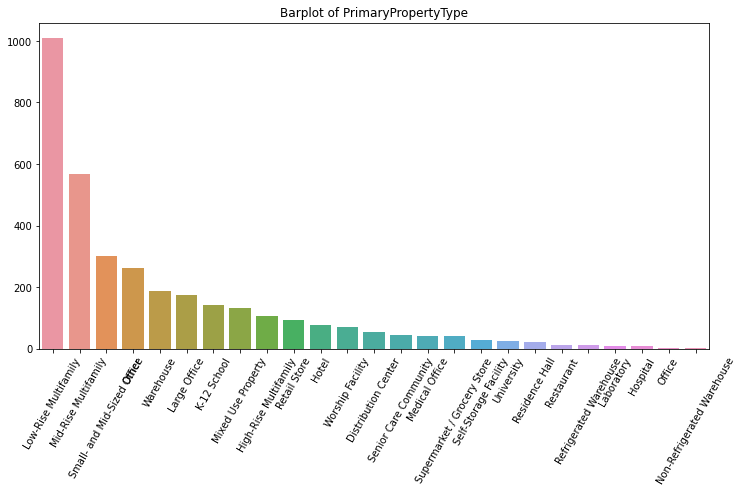

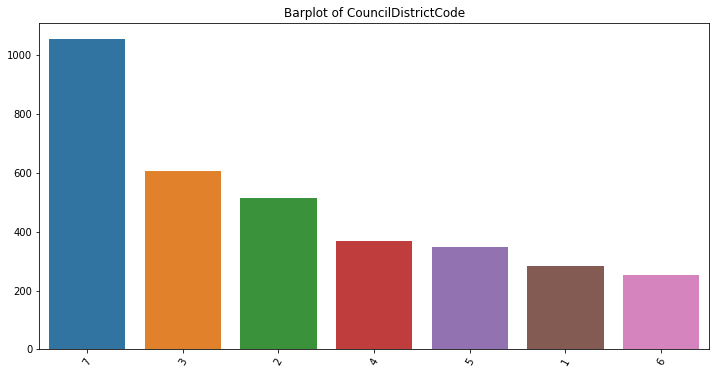

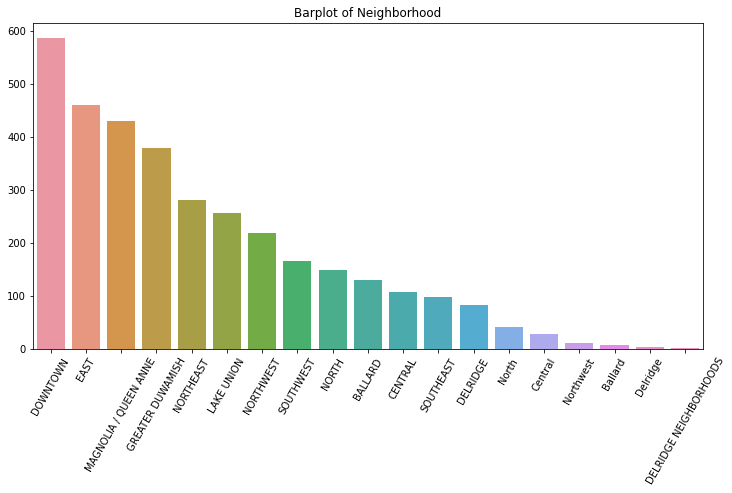

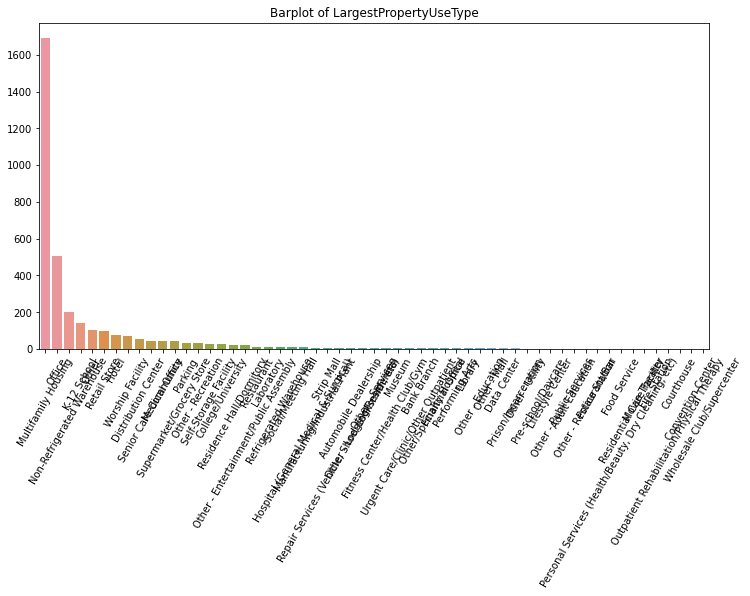

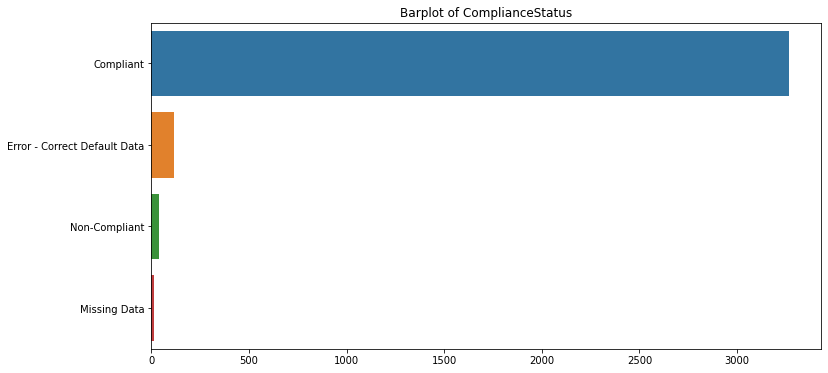

In [40]:
def plot_barplot(y):
    plt.title("Barplot of "+y.name)
    if y.value_counts().shape[0] > 5 : 
        ax = sns.barplot(x=y.index, y=y.values, order =y.sort_values(ascending=False).index)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
    else:
        sns.barplot(x=y.values, y=y.index, order=y.sort_values(ascending=False).index)

for colname in cat_training_var:
    plt.figure(figsize=(12, 6))
    y = data[colname].value_counts().sort_values(ascending=False)
    plot_barplot(y)
    plt.show()

## Etude des deux variables de réponse 

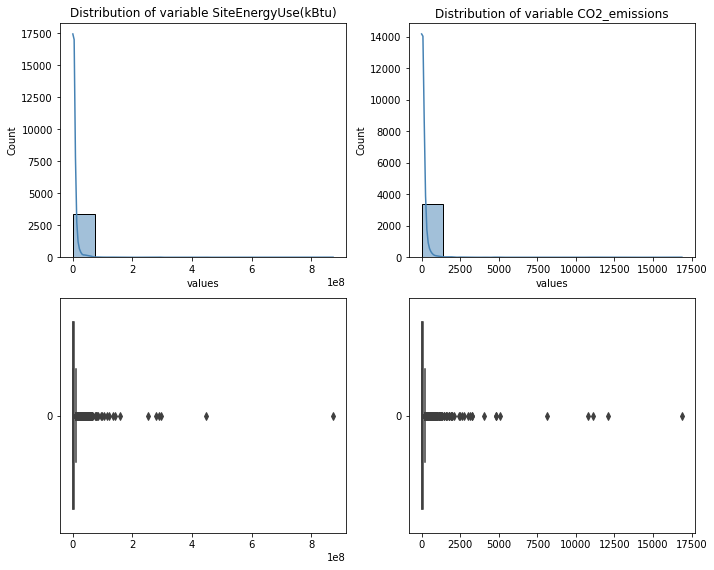

,SiteEnergyUse(kBtu),CO2_emissions
count,3.432000e+03,3432.000000
mean,5.396848e+06,119.213905
std,2.151952e+07,533.984645
min,9.313226e-10,0.090000
25%,9.293125e+05,9.568750
50%,1.791223e+06,33.757500
75%,4.197331e+06,91.890000
max,8.739237e+08,16870.980000


In [41]:
Y = data[["SiteEnergyUse(kBtu)","CO2_emissions"]]
univariate_analysis.plot_multi_hist_and_boxplot(Y,nb_fig_in_line=2,figsize=(10,8))
plt.show()
Y.describe()

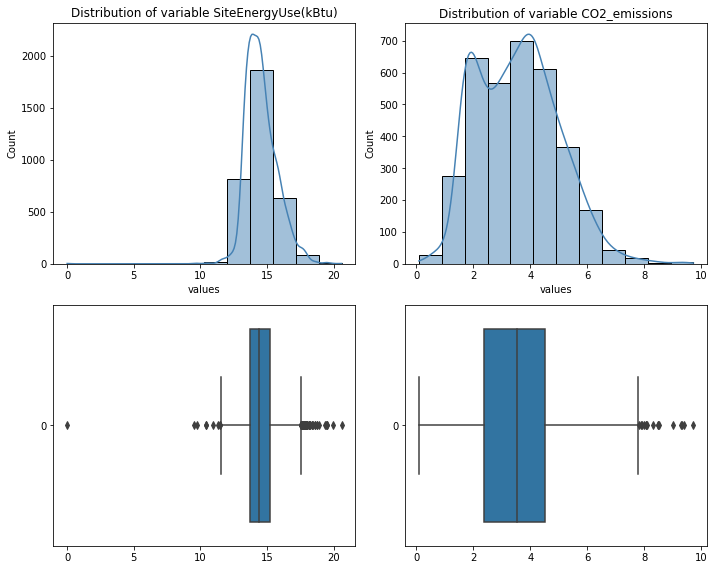

In [42]:
Y_log = np.log(data[["SiteEnergyUse(kBtu)","CO2_emissions"]]+1)
univariate_analysis.plot_multi_hist_and_boxplot(Y_log,nb_fig_in_line=2,figsize=(10,8))
plt.show()

dict_log = {var: True for var in num_output_var}

SiteEnergyUse(kBtu) :
	 gini = 0.696007335879355
	 AUC = 0.1519963320603225
CO2_emissions :
	 gini = 0.7558013094327201
	 AUC = 0.12209934528363998


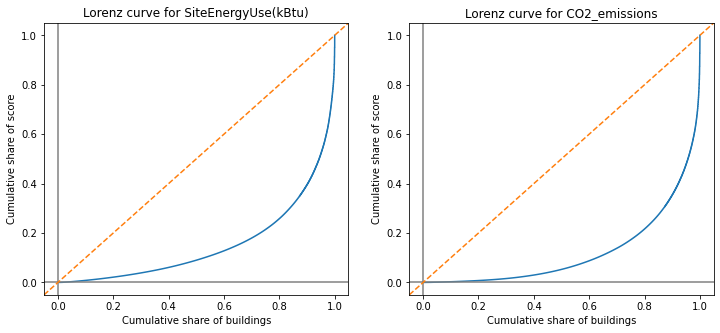

In [43]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
univariate_analysis.plot_lorenz_curve(Y.iloc[:,0])
plt.subplot(1,2,2)
univariate_analysis.plot_lorenz_curve(Y.iloc[:,1])

# 4. Analyse multivariée :



In [44]:
num_data = data[np.concatenate((num_training_var,[ "CO2_emissions", "SiteEnergyUse(kBtu)"]))]
num_data.head()

,ZipCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseTypeGFA,age_of_building,CO2_emissions,SiteEnergyUse(kBtu)
0,58091.0,1.0,12.0,0.0,88434.0,88.5,249.705,7103895.25
1,58091.0,1.0,11.0,15064.0,83880.0,19.5,279.685,8371084.00
2,58091.0,1.0,41.0,98359.0,756868.0,46.5,2075.380,72858840.00
3,58091.0,1.0,10.0,0.0,61320.0,89.5,1111.385,17511952.00
4,58848.5,1.0,18.0,37230.0,123445.0,35.5,506.355,14500852.50


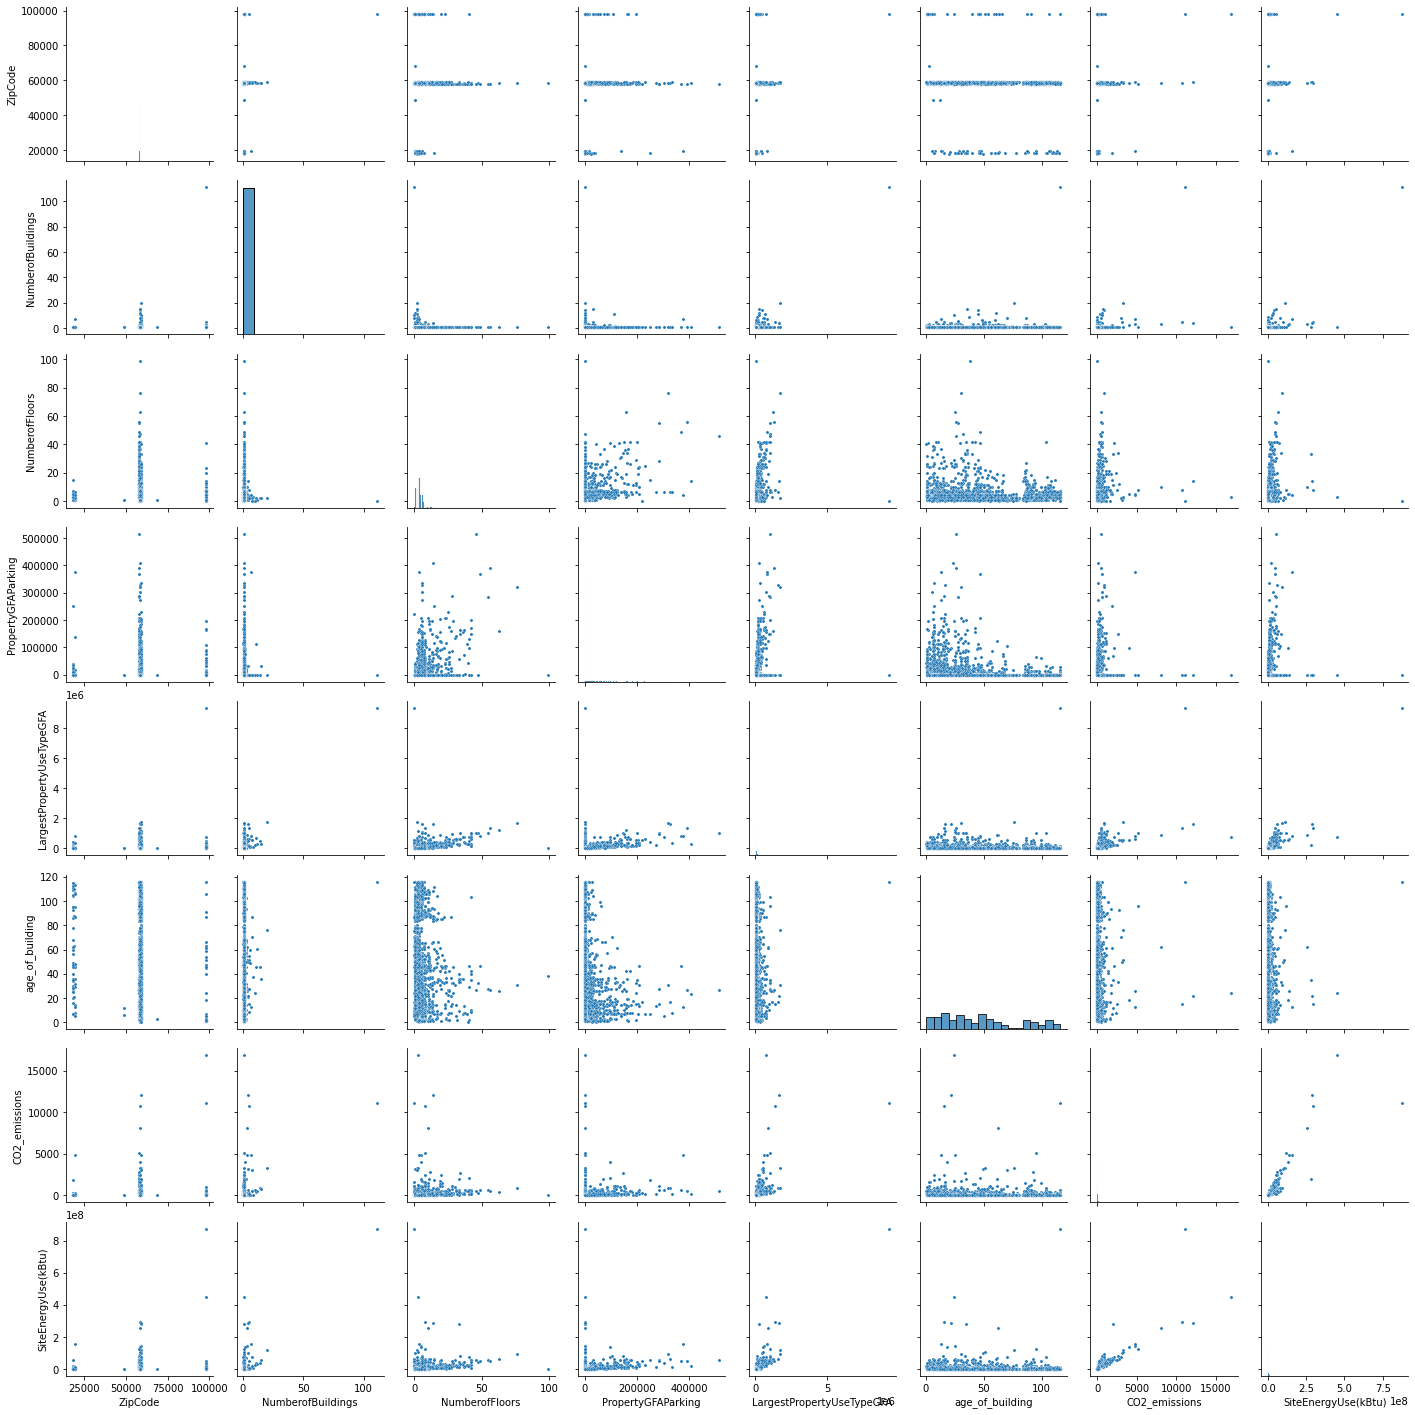

In [45]:
sns.pairplot(num_data, diag_kind="hist", plot_kws={"s": 10, "alpha":1})

Table avec les variables en log-transform : 

In [46]:

dict_var_log_transfo["SiteEnergyUse(kBtu)"]=True 
dict_var_log_transfo["CO2_emissions"]=True 
def df_log_transform(X_, num_var = []):
    ## set num var :
    if len(num_var) == 0 :
        num_var = X_.columns[X_.dtypes==float].values
    else : 
        num_var = X_.columns.intersection(num_var)
    ## init res 
    X_log = X_.copy()
    X_log_num = X_log[num_var]
    ## replace neg values with 0 : 
    index_negative = np.where(X_log_num<10**(-9))
    for i in range(len(index_negative[0])):
        X_log_num.iat[index_negative[0][i],index_negative[1][i]] = 0
    index_inf = np.where(X_log_num>10**9)
    for i in range(len(index_inf[0])):
        X_log_num.iat[index_inf[0][i],index_inf[1][i]] = 0
    X_log.at[:,num_var] = np.log(X_log_num + 1)
    return(X_log)

log_num_var = [var for var in dict_var_log_transfo.keys() if dict_var_log_transfo[var]]
data_log_transfo = df_log_transform(data, log_num_var)

## Consommation d'énergie

### Consommation d'énergie VS variables numériques
Commençons par une régression linéaire entre la variable de sortie ```SiteEnergyUse(kBtu)``` avec les variables du permis de construction : 

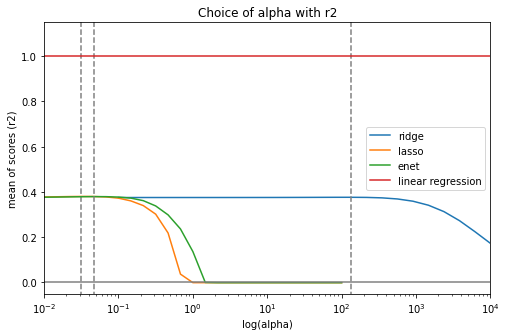

ridge  : 


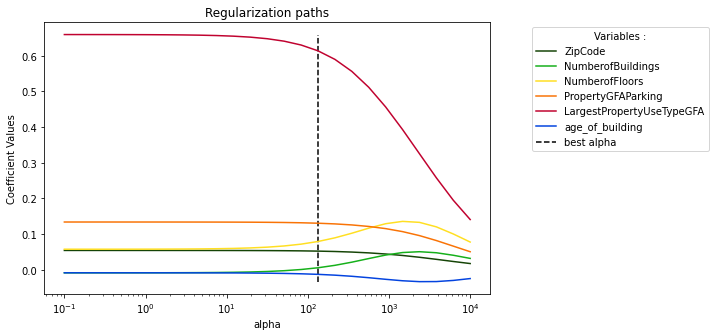

lasso  : 


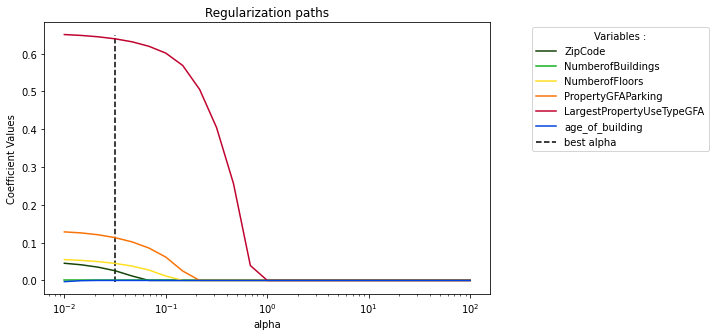

enet  : 


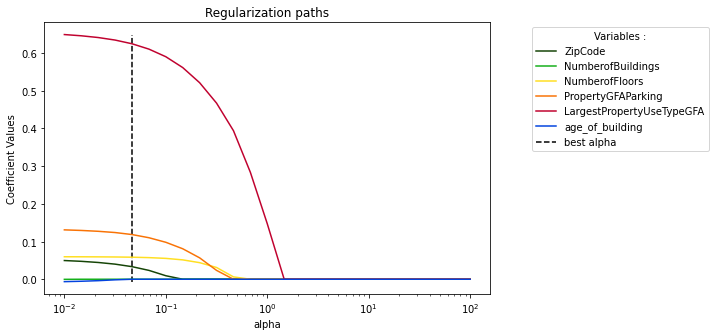

,score,execution_time,best_alpha
lr,1.0,0.003415,None
ridge,0.352483,0.068507,133.352143
lasso,0.155703,0.118128,0.031623
enet,0.175251,0.126099,0.046416


In [47]:
from multivariate_analysis import *

# y = data["SiteEnergyUse(kBtu)"]
# X = data[num_training_var]

y = data_log_transfo["SiteEnergyUse(kBtu)"].copy()
X = data_log_transfo[num_training_var].copy()

# CV for LR init
dict_lr_model= {"ridge" : linear_model.Ridge(),
                "lasso" : linear_model.Lasso(),
                "enet" : linear_model.ElasticNet()}
dict_param_grid = {"ridge": np.logspace(-1, 4, 25),
                   "lasso": np.logspace(-2, 2, 25),
                   "enet" : np.logspace(-2, 2, 25),
                  }
score_name = "r2"
# plot parameters
figsize = (8,5)
fig_name = None ## change to save plot

compute_LR_CV(X, y, dict_lr_model, dict_param_grid, score_name, figsize, fig_name)

## reset params in model


La variable "age of building" ne semble avoir aucun impacte sur la prediction de la consommation d'énergie (coefficients lasso = 0) . Si elle a le même comportement avec la variable de consommation d'énergie, elle serait à retirer.

### Consommation d'énergie VS variables catégorielles : 

nb : j'ai gardé l'échelle logarithmique pour l'ANOVA qui suit. 

SiteEnergyUse(kBtu) : eta² = 0.19


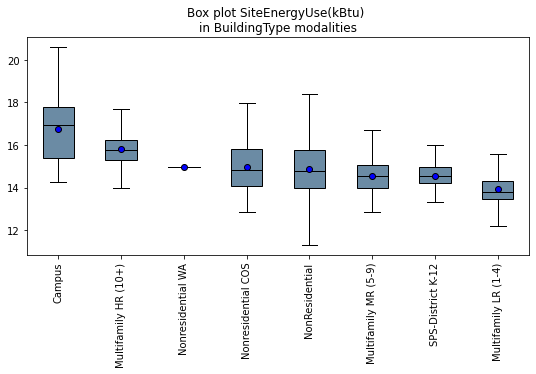

SiteEnergyUse(kBtu) : eta² = 0.41


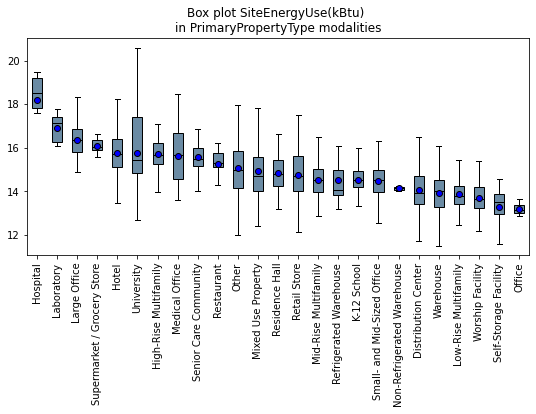

SiteEnergyUse(kBtu) : eta² = 0.05


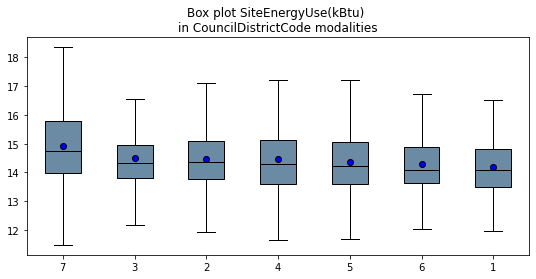

SiteEnergyUse(kBtu) : eta² = 0.1


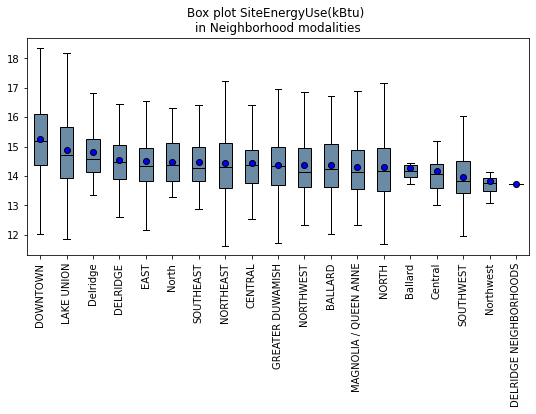

SiteEnergyUse(kBtu) : eta² = 0.28


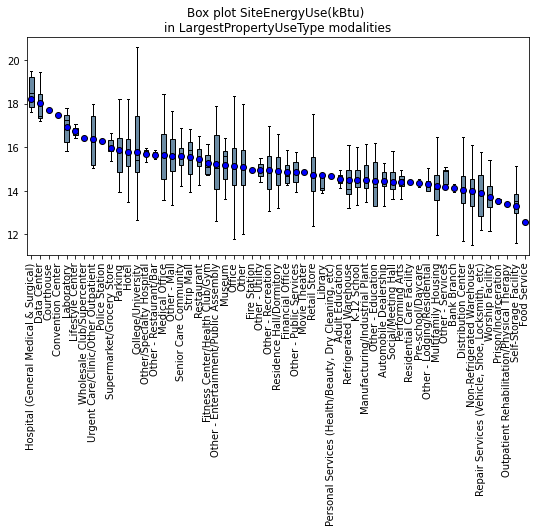

SiteEnergyUse(kBtu) : eta² = 0.02


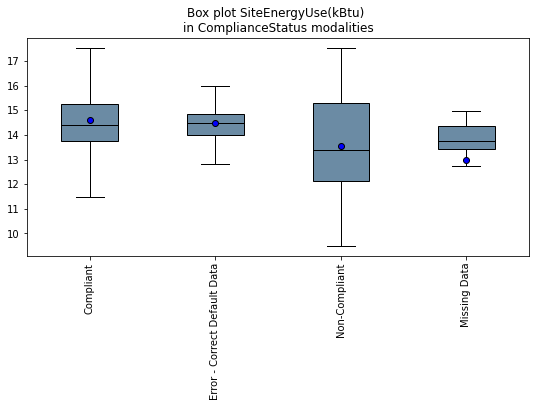

In [48]:
num_var="SiteEnergyUse(kBtu)"
for cat_var in cat_training_var :
    plt.figure(figsize=(9,4))
    plot_boxplot(data_log_transfo, cat_var, 
                 num_var="SiteEnergyUse(kBtu)",sort=True)
    eta2 = eta_squared(x=data[cat_var], y= data_log_transfo["SiteEnergyUse(kBtu)"])
    print(num_var, ": eta² =",np.round(eta2,2))
    plt.show()

Cette ANOVA nous permet de sélectionner les variables catégorielles pour lesquelles la variable "consommation d'énergie" est significativement différentes dans les modalités. J'ai donc gardé les variables dont l'indice $\eta^2$ est supérieur à $0.1$, j'ai donc retiré ```CouncilDistrictCode```, ```ComplianceStatus``` et ```Neighborhood``` des variables d'entrainement pour la consommation d'énergie. 

## Emission de CO2 


### Emission de CO2 VS variables numériques

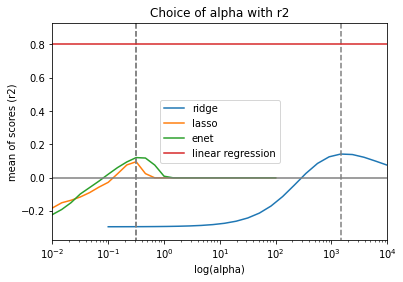

ridge  : 


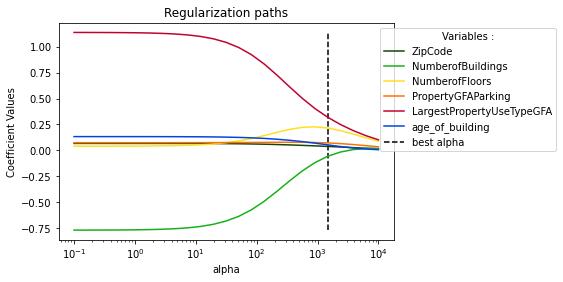

lasso  : 


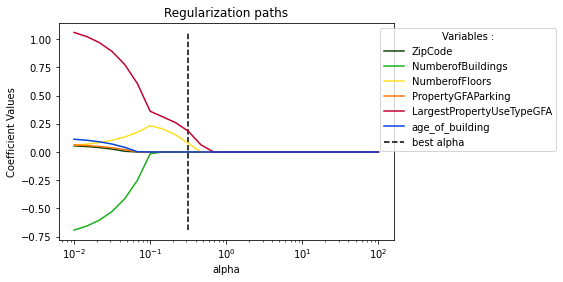

enet  : 


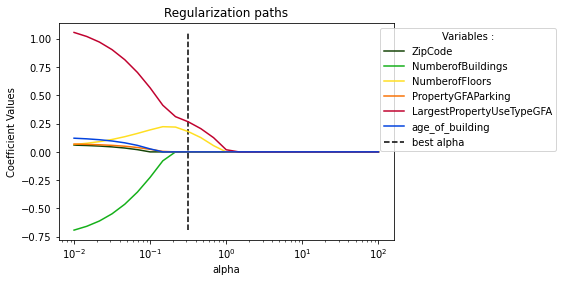

,score,execution_time,best_alpha
lr,0.8,0.002938,None
ridge,-0.137618,0.070439,1467.799268
lasso,-0.023002,0.139819,0.316228
enet,-0.011058,0.156045,0.316228


In [49]:
# y = data["CO2_emissions"]
# X = data[num_training_var]
y = data_log_transfo["CO2_emissions"]
X = data_log_transfo[num_training_var]

# CV for LR init
alpha_values =  np.logspace(-2, 3, 50)
dict_lr_model= {"ridge" : linear_model.Ridge(), "lasso" : linear_model.Lasso(),
                "enet" : linear_model.ElasticNet()}
score_name = "r2"
# plot parameters
figsize = (8,5)
fig_name = None ## change to save plot

compute_LR_CV(X, y, dict_lr_model, dict_param_grid, score_name, fig_name)

La variable d'age du batiment n'a pas non plus d'effet fort sur la consommation d'énergie, je la retire de cette étude. 

In [50]:
data_log_transfo = data_log_transfo.drop("age_of_building", axis =1)
data = data.drop("age_of_building", axis =1)

BuildingType : eta² = 0.10160884523757839


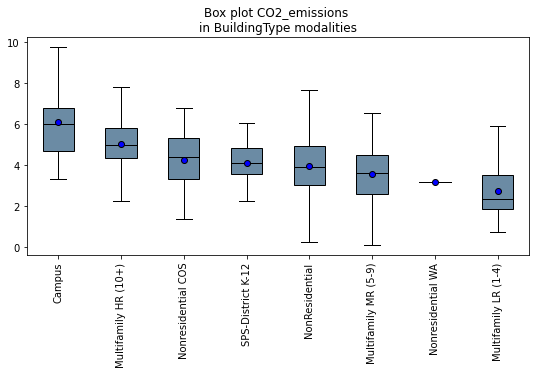

PrimaryPropertyType : eta² = 0.2838630182303584


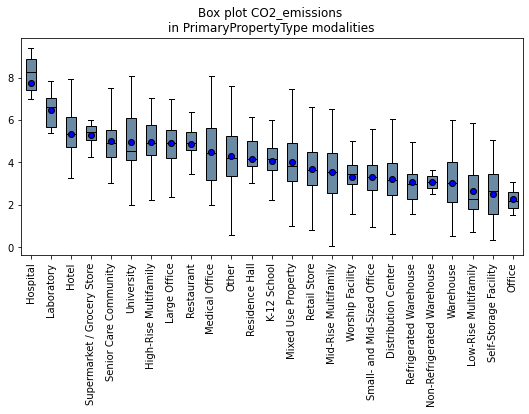

CouncilDistrictCode : eta² = 0.004840420006678315


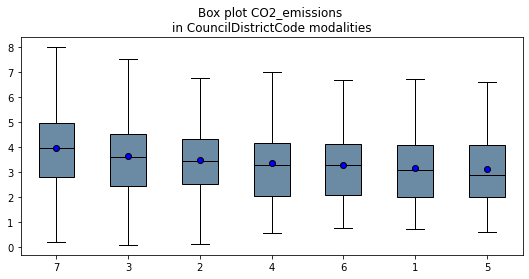

Neighborhood : eta² = 0.007600337541355873


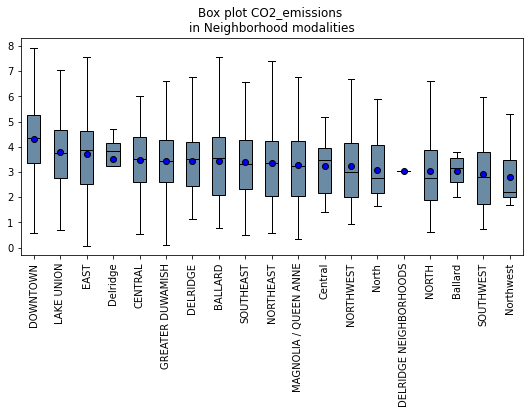

LargestPropertyUseType : eta² = 0.2815021040611555


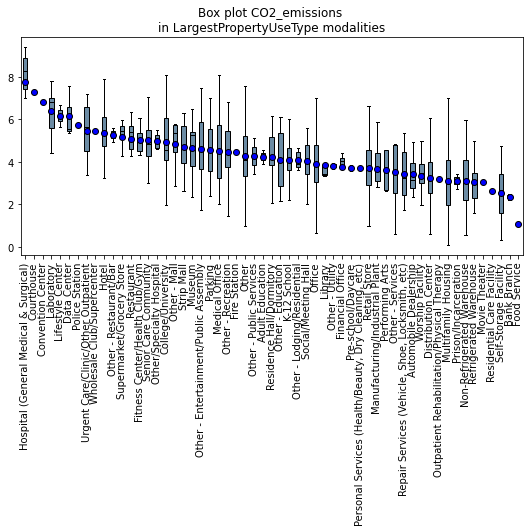

ComplianceStatus : eta² = 0.00037762678523310157


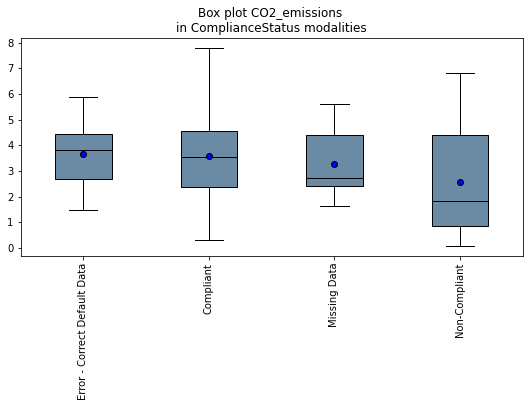

In [51]:
for var in cat_training_var :
    plt.figure(figsize=(9,4))
    plot_boxplot(data_log_transfo, var, "CO2_emissions",sort=True)
    eta2 = eta_squared(x=data_log_transfo[var], y=data["CO2_emissions"])
    print(var, ": eta² =",eta2)
    plt.show()

De la même façon que pour la consommation d'énergie, l'émission de CO2 n'a pas de structure forte pour les variables ```CouncilDistrictCode``` et ```ComplianceStatus``` que je vais donc retirer des variables d'entrainement. Par ailleurs, il serait pertinent d'essayer de regrouper les quartiers (variable ```Neighborhood```), car il y a l'air d'y avoir 3 ou 4 régimes différents sur ces derniers.

In [52]:
cat_training_var = cat_training_var.drop(["CouncilDistrictCode","ComplianceStatus","Neighborhood"])

# L'Energy Star Score

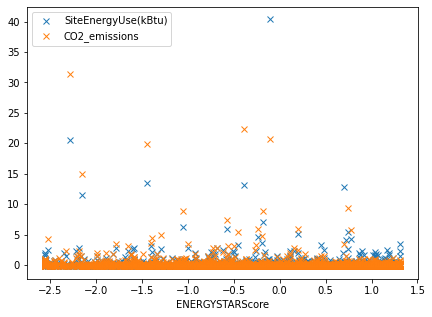

In [53]:
tmp = data[["ENERGYSTARScore", "SiteEnergyUse(kBtu)","CO2_emissions"]].copy()
# tmp = tmp.sort_values("ENERGYSTARScore")
my_std = preprocessing.StandardScaler()
tmp = pd.DataFrame(my_std.fit_transform(tmp),index=tmp.index, columns=tmp.columns)

plt.figure(figsize=(7,5))
plt.plot(tmp["ENERGYSTARScore"],tmp[["SiteEnergyUse(kBtu)","CO2_emissions"]],"x")
plt.legend(["SiteEnergyUse(kBtu)","CO2_emissions"])
plt.xlabel("ENERGYSTARScore")
plt.show()

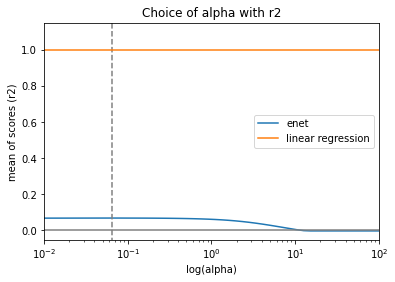

enet  : 


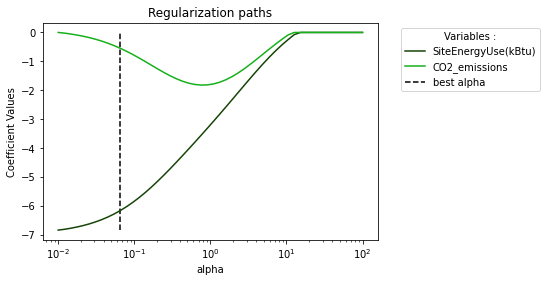

,score,execution_time,best_alpha
lr,1.0,0.002591,None
enet,0.041748,0.123697,0.065513


In [54]:

# y = data["CO2_emissions"]
# X = data[num_training_var]

y = data_log_transfo["ENERGYSTARScore"]
X = data_log_transfo[["SiteEnergyUse(kBtu)","CO2_emissions"]]
# X = data_log_transfo[np.concatenate((num_training_var,["SiteEnergyUse(kBtu)","CO2_emissions"]))]

# CV for LR init
# alpha_values =  np.logspace(-2, 2, 50)
dict_lr_model= {#"ridge" : linear_model.Ridge(), "lasso" : linear_model.Lasso(),
                "enet" : linear_model.ElasticNet()}
score_name = "r2"
# plot parameters
figsize = (8,5)
fig_name = None ## change to save plot

compute_LR_CV(X, y, dict_lr_model, {"enet":np.logspace(-2, 2, 50)}, score_name, fig_name)

In [55]:
# for var in cat_training_var :
#     plt.figure(figsize=(9,4))
#     plot_boxplot(data_log_transfo, var, "ENERGYSTARScore",sort=True)
#     eta2 = eta_squared(x=data_log_transfo[var], y=data["ENERGYSTARScore"])
#     print(var, ": eta² =",np.round(eta2,2))
#     plt.show()

# Extraction de la table de travail 

## Vectorisation des variables catégorielles 

Il va donc falloir tokentiser les 3 variables catégorielles ('BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType')

In [56]:
for var in cat_training_var :
    print(var, " : ", len(data[var].cat.categories)," catégories différentes")

BuildingType  :  8  catégories différentes
PrimaryPropertyType  :  25  catégories différentes
LargestPropertyUseType  :  57  catégories différentes


#### Clustering des modalités avec COP-KMeans

Ces variables ont un très grand nombre de catégories différentes, il me semble pertinent de chercher à regrouper ces catégories (selon la variable de sortie) avant de les vectoriser, afin d'éviter le fléau de la dimension. 

J'ai utilisé l'implémentation de COP-Kmeans proposée [sur ce github](https://github.com/Behrouz-Babaki/COP-Kmeans) et la fonction qui calcule le BIC a été extraite de [ce site](https://stats.stackexchange.com/questions/90769/using-bic-to-estimate-the-number-of-k-in-kmeans)

A noter : le résultat du code suivant ne devrait être lancé que dans le second notebook, sur l'ensemble d'apprentissage, pour éviter de surapprendre en faisant cette opération. Néansmoins, comme cela reste un pre-traitement, je présente la démarche ici.

##TODO : lancer ce code sur l'ensemble d'apprentissage plutôt qu'ici.

In [57]:
from copkmeans.cop_kmeans import cop_kmeans

In [58]:
## very long to run : save res in files
# list_of_cat_var = cat_training_var
# loop_on_cat_var_cluster_category(data_log_tran£sfo, num_vars, list_of_cat_var)

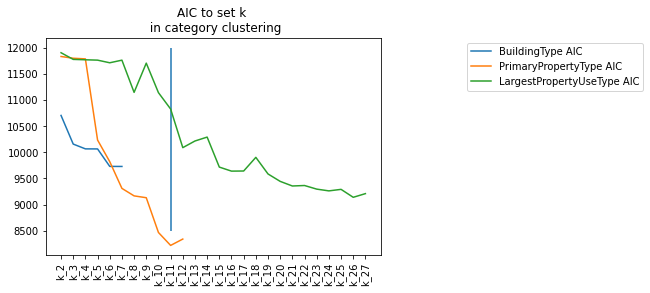

In [59]:
num_vars = ["SiteEnergyUse(kBtu)","CO2_emissions"]

list_of_cat_var = cat_training_var#[cat_training_var[0]]
my_legend = []
for cat_var in list_of_cat_var : 
    cluster_criterion = pd.read_csv(res_path+"set_k_cluster_category_"+ cat_var +".csv",
                                    index_col=0)["AIC"]
    plt.plot(cluster_criterion)
    my_legend = np.concatenate((my_legend,[cat_var+" AIC"]))
plt.xticks(rotation='vertical')
plt.legend(my_legend,loc = "upper right",bbox_to_anchor=(1.8, 1))
plt.title("AIC to set k \n in category clustering")

plt.vlines("k_11",ymin=8500,ymax = 12000)

This setting allowed me to set the better number of cluster for each categorical variable :

In [60]:
dict_best_k_category = { "BuildingType" : 5,
                         "PrimaryPropertyType" : 11,
                         "Neighborhood": 4,
                         "LargestPropertyUseType" : 15}
## construct df with clustering results :
res_cluster = data_log_transfo[num_vars].copy()
for cat_var in cat_training_var :
    x = data_log_transfo[cat_var]
    must_link = get_must_link(data[cat_var])
    k = dict_best_k_category[cat_var]
#     clusters, centers = cluster_categories(x,res_cluster[num_vars], k=k, must_link = must_link)
    ##hack to solve if one dimensionnal Y : 
    Y = pd.concat([res_cluster["SiteEnergyUse(kBtu)"],res_cluster["SiteEnergyUse(kBtu)"]], axis =1)#num_vars
    clusters, centers = cluster_categories(x,Y, k=k, must_link = must_link)
    res_cluster.at[:,cat_var] = clusters
    res_cluster[cat_var] = res_cluster[cat_var].astype("category")
    

In [61]:
## change modalities in category if there is only one in cluster 
## + extract dictionary of correspondance cluster/variables
dict_corresp_cluster = {}

res_cluster2 = res_cluster.copy()
for cat_var in cat_training_var :
    original = data[cat_var]
    cluster = res_cluster2[cat_var]
    dict_rename_cat = {}
    dict_corresp_cluster_var = get_corresp_cluster_var(original, cluster)
    for clust_k, modalities in dict_corresp_cluster_var.items() :
        if len(modalities)==1:
            dict_rename_cat[clust_k] = modalities[0]
        dict_corresp_cluster[cat_var+"_"+str(clust_k)] = modalities
    #         res_cluster.at[res_cluster[cat_var]==clust_k,cat_var] = modalities[0]
    res_cluster2[cat_var] = res_cluster2[cat_var].cat.rename_categories(dict_rename_cat)
# dict_corresp_cluster

BuildingType original : eta² = 0.2
BuildingType clustered : eta² = 0.19


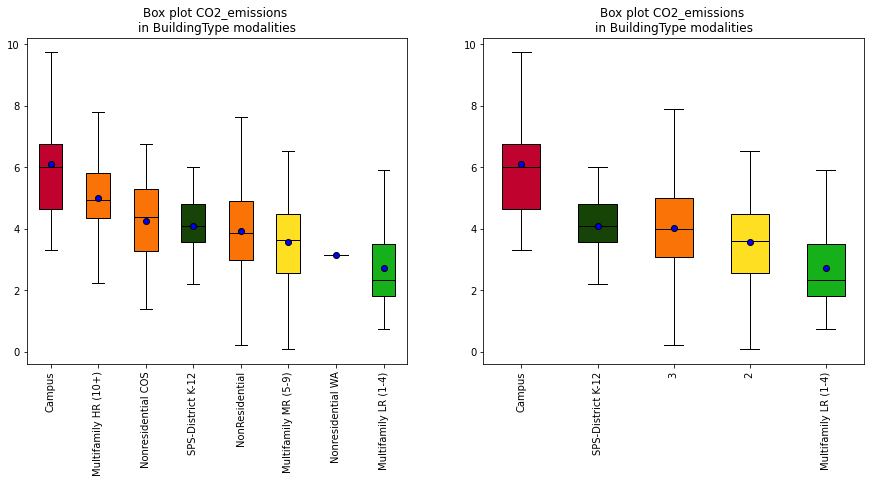

PrimaryPropertyType original : eta² = 0.36
PrimaryPropertyType clustered : eta² = 0.29


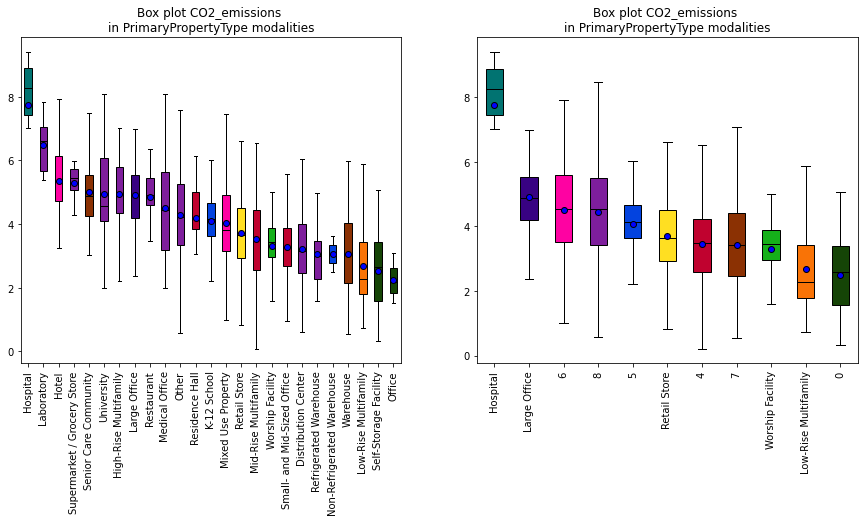

LargestPropertyUseType original : eta² = 0.24
LargestPropertyUseType clustered : eta² = 0.14


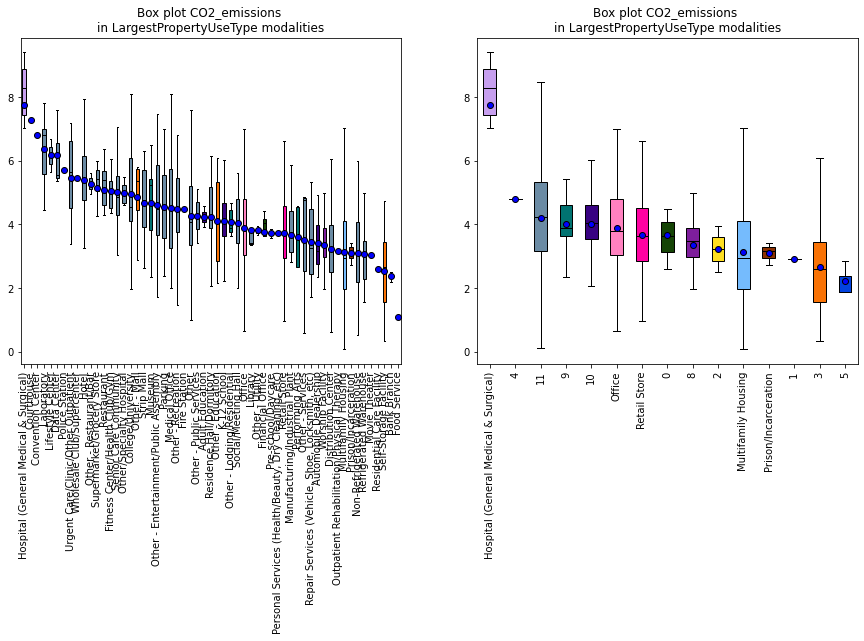

In [62]:
figsize = (15,6)
num_var = "CO2_emissions"
for cat_var in cat_training_var :
    compare_boxplots_clustered_category_COPkmeans(res_cluster2, data_log_transfo,  
                                    cat_var, num_var, figsize =figsize)
    plt.show()

BuildingType original : eta² = 0.19
BuildingType clustered : eta² = 0.17
{0: array(['SPS-District K-12'], dtype=object), 1: array(['Multifamily LR (1-4)'], dtype=object), 2: array(['Multifamily MR (5-9)', 'Nonresidential WA'], dtype=object), 3: array(['Multifamily HR (10+)', 'NonResidential', 'Nonresidential COS'],
      dtype=object), 4: array(['Campus'], dtype=object)}


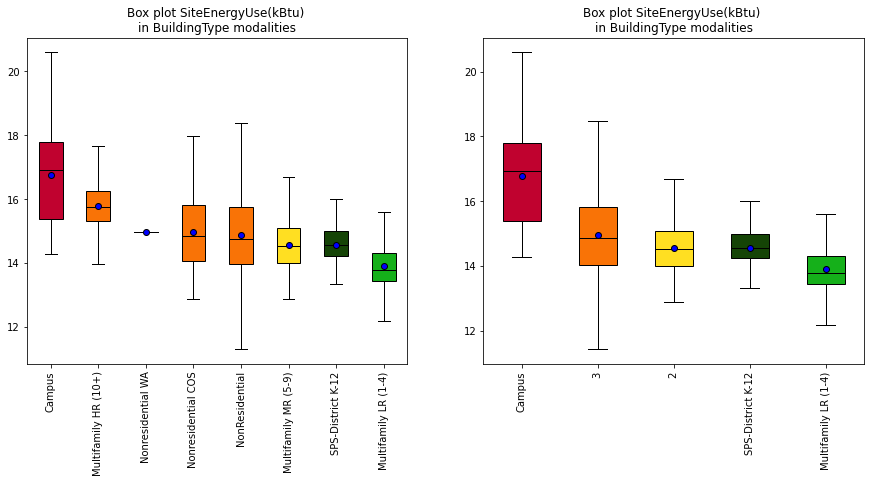

PrimaryPropertyType original : eta² = 0.41
PrimaryPropertyType clustered : eta² = 0.35
{0: array(['Office', 'Self-Storage Facility'], dtype=object), 1: array(['Worship Facility'], dtype=object), 2: array(['Retail Store'], dtype=object), 3: array(['Low-Rise Multifamily'], dtype=object), 4: array(['Mid-Rise Multifamily', 'Residence Hall',
       'Small- and Mid-Sized Office'], dtype=object), 5: array(['K-12 School', 'Non-Refrigerated Warehouse'], dtype=object), 6: array(['Hotel', 'Mixed Use Property'], dtype=object), 7: array(['Senior Care Community', 'Warehouse'], dtype=object), 8: array(['Distribution Center', 'High-Rise Multifamily', 'Laboratory',
       'Medical Office', 'Other', 'Refrigerated Warehouse', 'Restaurant',
       'Supermarket / Grocery Store', 'University'], dtype=object), 9: array(['Hospital'], dtype=object), 10: array(['Large Office'], dtype=object)}


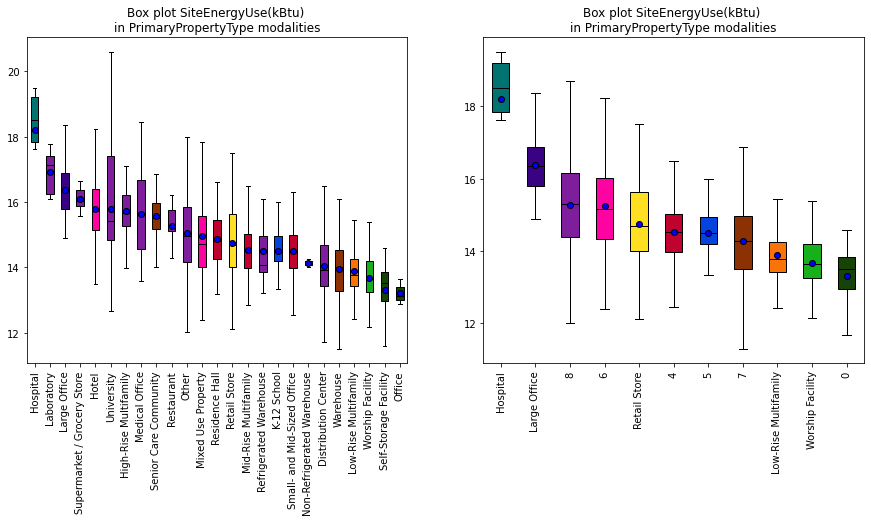

LargestPropertyUseType original : eta² = 0.28
LargestPropertyUseType clustered : eta² = 0.16
{0: array(['Financial Office', 'Fire Station', 'Movie Theater'], dtype=object), 1: array([], dtype=object), 2: array([], dtype=object), 3: array(['Food Service', 'Other - Education', 'Other - Mall',
       'Outpatient Rehabilitation/Physical Therapy',
       'Self-Storage Facility'], dtype=object), 4: array([], dtype=object), 5: array([], dtype=object), 6: array(['Retail Store'], dtype=object), 7: array(['Prison/Incarceration'], dtype=object), 8: array(['Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Worship Facility'], dtype=object), 9: array(['Museum', 'Other - Lodging/Residential', 'Other - Utility',
       'Performing Arts', 'Residential Care Facility'], dtype=object), 10: array(['Adult Education', 'Automobile Dealership', 'Bank Branch',
       'K-12 School', 'Pre-school/Daycare'], dtype=object), 11: array(['College/University', 'Convention Center', 'Courthouse',
       'Dat

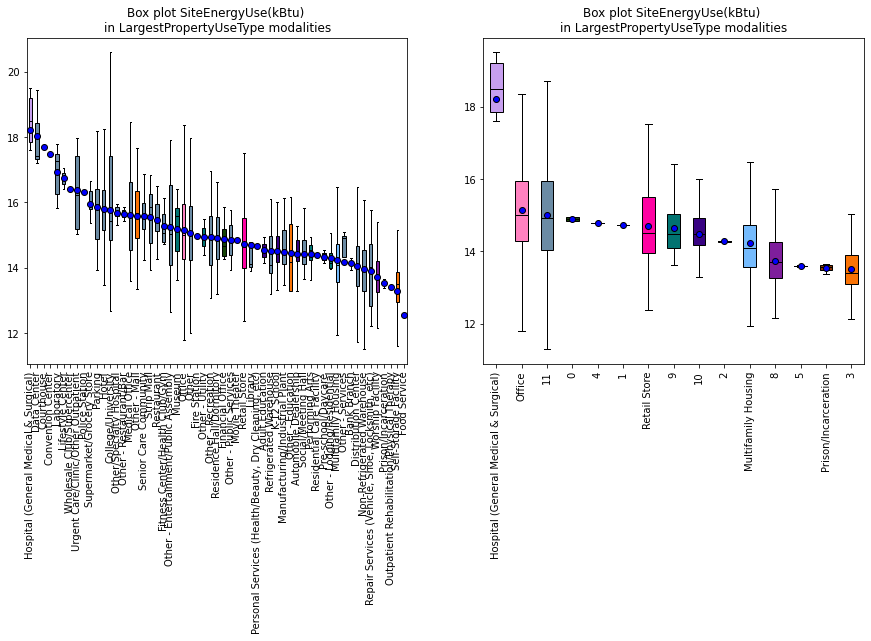

In [63]:
figsize = (15,6)
num_var = "SiteEnergyUse(kBtu)"
for cat_var in cat_training_var :
    compare_boxplots_clustered_category_COPkmeans(res_cluster2, data_log_transfo,  
                                    cat_var, num_var, figsize =figsize)
    dict_corresp_cluster_var = get_corresp_cluster_var(data[cat_var], res_cluster[cat_var])
    print(dict_corresp_cluster_var)
    plt.show()

#### Clustering des modalités à la main :
pour faciliter la lecture des groupes à la main : 

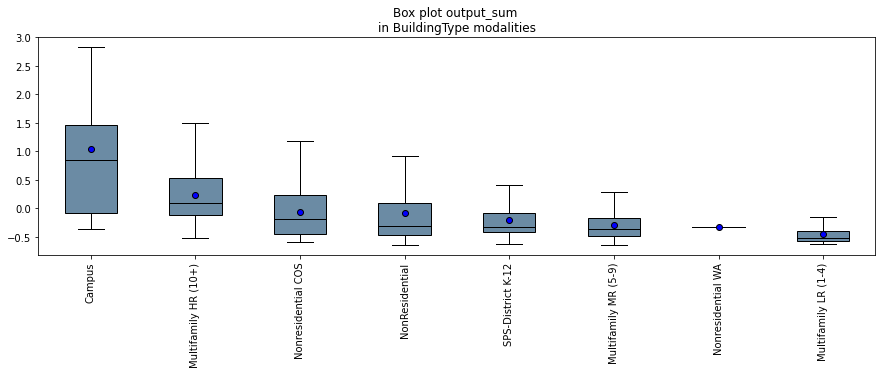

In [64]:
plt.figure(figsize=(15,4))
output_std_sum = pd.DataFrame(StandardScaler().fit_transform(data[num_vars]))
output_std_sum = np.log(output_std_sum.sum(axis=1)+1)
output_std_sum = output_std_sum.rename("output_sum")
tmp = pd.concat((output_std_sum ,data[cat_training_var]),axis =1)
plot_boxplot(tmp, "BuildingType", "output_sum",sort=True)
plt.show()


In [65]:
from preprocess import *
cat_training_var = dict_cluster.keys()

res_cluster = data_log_transfo[np.concatenate((list(dict_cluster.keys()),["SiteEnergyUse(kBtu)","CO2_emissions"]))].copy()
for var in dict_cluster.keys() :
    cluster_var = dict_cluster[var]

    tmp = pd.Series(index = res_cluster.index, dtype = "category", name=var)
    tmp = tmp.cat.set_categories(cluster_var.keys())
    for cluster, list_categories in cluster_var.items():
        for category in list_categories:
            category_index = res_cluster[res_cluster[var] == category].index
            tmp[category_index] = cluster
    res_cluster = res_cluster.drop(var, axis = 1)
    res_cluster = pd.concat((res_cluster,tmp), axis = 1)


BuildingType original : eta² = 0.19
BuildingType clustered : eta² = 0.17


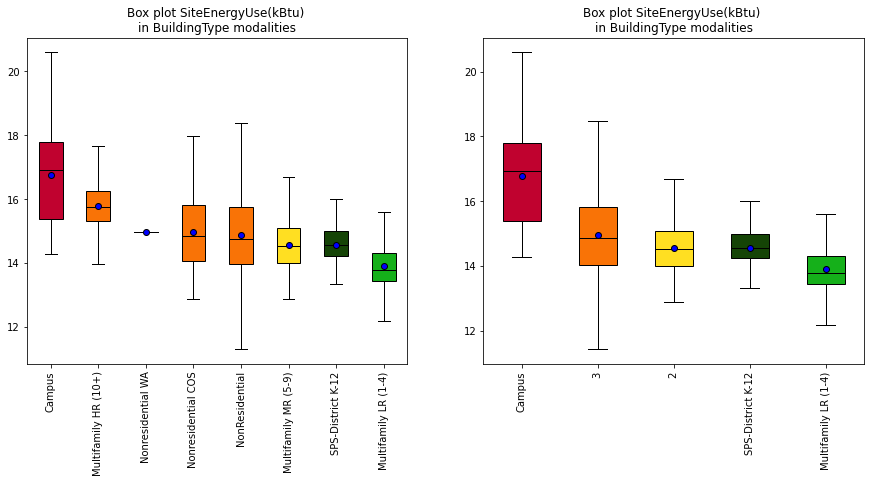

PrimaryPropertyType original : eta² = 0.41
PrimaryPropertyType clustered : eta² = 0.35


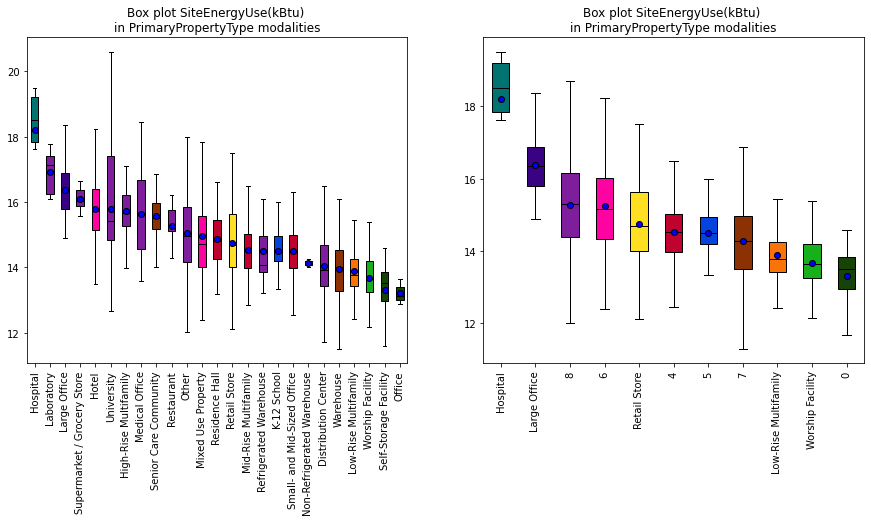

In [66]:
figsize = (15,6)
num_var = "SiteEnergyUse(kBtu)"
for cat_var in dict_cluster.keys() :
    compare_boxplots_clustered_category_COPkmeans(res_cluster2, data_log_transfo,  
                                    cat_var, num_var, figsize =figsize)
    plt.show()

In [67]:
data_log_transfo["PrimaryPropertyType"].cat.categories

Index(['Distribution Center', 'High-Rise Multifamily', 'Hospital', 'Hotel',
       'K-12 School', 'Laboratory', 'Large Office', 'Low-Rise Multifamily',
       'Medical Office', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'Non-Refrigerated Warehouse', 'Office', 'Other',
       'Refrigerated Warehouse', 'Residence Hall', 'Restaurant',
       'Retail Store', 'Self-Storage Facility', 'Senior Care Community',
       'Small- and Mid-Sized Office', 'Supermarket / Grocery Store',
       'University', 'Warehouse', 'Worship Facility'],
      dtype='object')

In [68]:
dict_cluster

{'BuildingType': {'campus': ['Campus'],
  'HR': ['Multifamily HR (10+)'],
  'ML': ['Multifamily MR (5-9)'],
  'LR': ['Multifamily LR (1-4)'],
  'other': ['Nonresidential WA',
   'Nonresidential COS',
   'NonResidential',
   'SPS-District K-12']},
 'PrimaryPropertyType': {'medical': ['Hospital', 'Laboratory'],
  'large': ['Large Office', 'Supermarket / Grocery Store'],
  'service': ['Hotel',
   'University',
   'High-Rise Multifamily',
   'Medical Office',
   'Senior Care Community',
   'Restaurant'],
  'other': ['Other', 'Mixed Use Property', 'Retail Store', 'Residence Hall'],
  'medium': ['Mid-Rise Multifamily',
   'Refrigerated Warehouse',
   'K-12 School',
   'Small- and Mid-Sized Office'],
  'empty': ['Non-Refrigerated Warehouse', 'Distribution Center', 'Warehouse'],
  'small': ['Low-Rise Multifamily,Worship Facility'],
  'other2': ['Self-Storage Facility', 'Office']}}

BuildingType original : eta² = 0.19
BuildingType clustered : eta² = 0.18


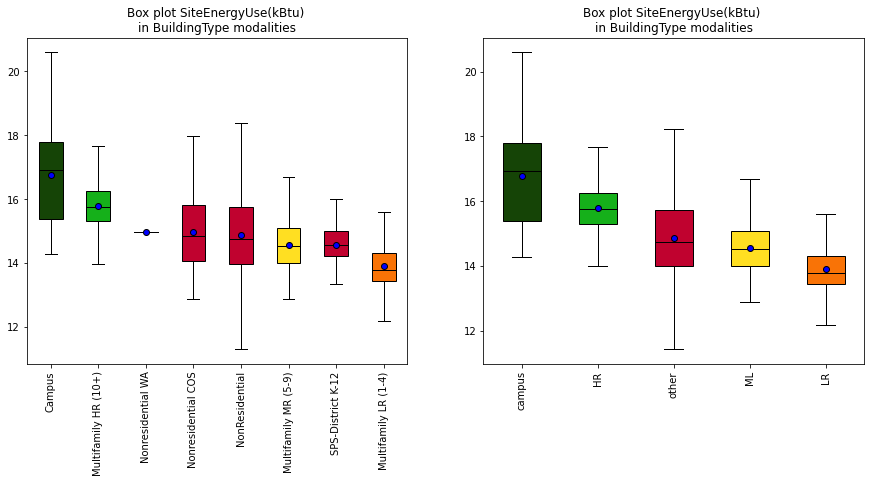

PrimaryPropertyType original : eta² = 0.41
PrimaryPropertyType clustered : eta² = 0.33


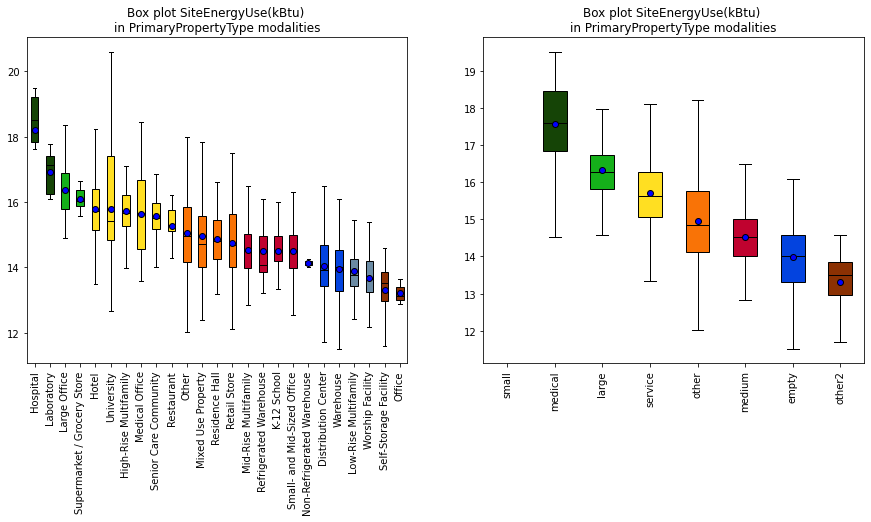

BuildingType original : eta² = 0.2
BuildingType clustered : eta² = 0.2


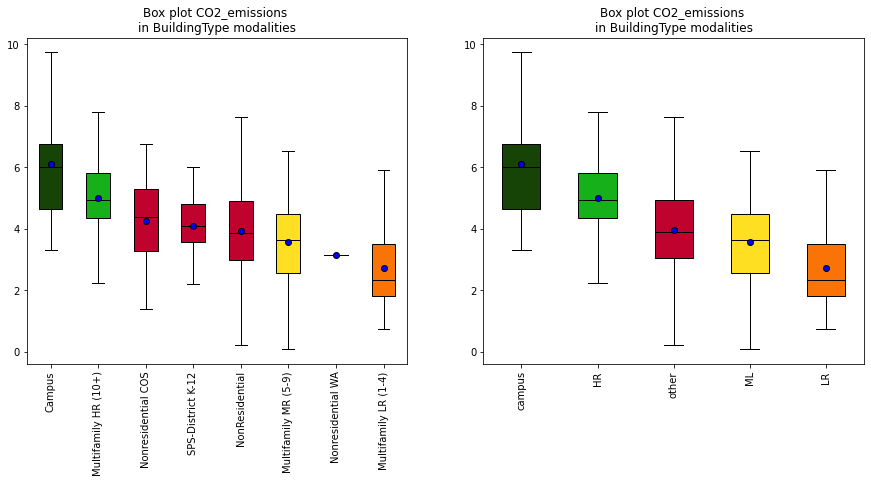

PrimaryPropertyType original : eta² = 0.36
PrimaryPropertyType clustered : eta² = 0.26


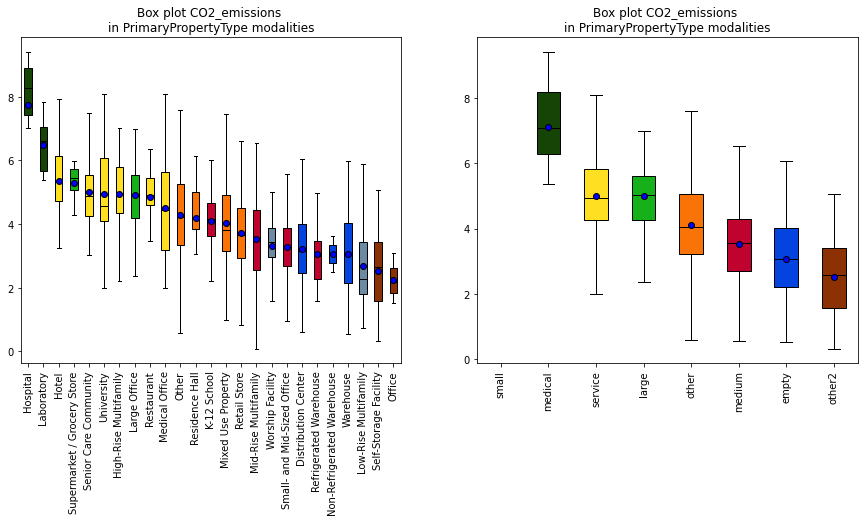

In [69]:
num_var = "SiteEnergyUse(kBtu)"
for cat_var in  cat_training_var:
    compare_boxplots_clustered_category_COPkmeans(res_cluster, data_log_transfo,  
                                    cat_var, num_var, figsize =figsize)
    plt.show()

num_var = "CO2_emissions"
for cat_var in cat_training_var :
    compare_boxplots_clustered_category_COPkmeans(res_cluster, data_log_transfo,  
                                    cat_var, num_var, figsize =figsize)
    plt.show()

## WORK IN PROCESS ... 
Ce travail n'est pas fini (attente ref/ aller en chercher, faire le travail de dev sur l'échantillon  d'entrainement ...) Le clustering n'est pas très satisfaisant, puisqu'il regroupe des groupes avec des moyennes assez différentes (pas à côté dans le boxplot). 

En attendant, je ne vais vectoriser ces modalités regroupées à la main, pour les variables "BuildingType" et "PrimaryPropertyType", pour passer à la suite. Pour faire mieux, je verrai plus tard, si j'en ai le temps.

nb : je n'ai pas fait le traitement à la maisn pour "LargestPropertyUseType", car c'était fastidieux, que la variable a l'air de faire doublon avec "PrimaryPropertyType", et représente moins bien la structure des variables de réponse. 

In [70]:
## plusieurs methodes possibles via sklearn, ex : 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## data avec var de rep et num_train

selected_var = np.concatenate((num_training_var,["SiteEnergyUse(kBtu)","CO2_emissions","ENERGYSTARScore"]))
new_data = data[data.columns.intersection(selected_var)].copy()

## j'utilise la methode de pandas : 
for cat_var in cat_training_var : 
    cat_data = pd.get_dummies(res_cluster[cat_var])
    cat_data = cat_data.add_prefix(cat_var+"_")
    new_data = new_data.merge(cat_data, left_index=True, right_index=True)

In [71]:
new_data.to_csv(res_path+"cleanned_data.csv")
new_data = pd.read_csv(res_path+"cleanned_data.csv", index_col=0)
new_data

,ZipCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),CO2_emissions,BuildingType_campus,BuildingType_HR,...,BuildingType_LR,BuildingType_other,PrimaryPropertyType_medical,PrimaryPropertyType_large,PrimaryPropertyType_service,PrimaryPropertyType_other,PrimaryPropertyType_medium,PrimaryPropertyType_empty,PrimaryPropertyType_small,PrimaryPropertyType_other2
0,58091.0,1.0,12.0,0.0,88434.0,62.5,7.103895e+06,249.705,0,0,...,0,1,0,0,1,0,0,0,0,0
1,58091.0,1.0,11.0,15064.0,83880.0,56.0,8.371084e+06,279.685,0,0,...,0,1,0,0,1,0,0,0,0,0
2,58091.0,1.0,41.0,98359.0,756868.0,30.5,7.285884e+07,2075.380,0,0,...,0,1,0,0,1,0,0,0,0,0
3,58091.0,1.0,10.0,0.0,61320.0,28.5,1.751195e+07,1111.385,0,0,...,0,1,0,0,1,0,0,0,0,0
4,58848.5,1.0,18.0,37230.0,123445.0,71.0,1.450085e+07,506.355,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3427,18377.0,1.0,3.0,8685.0,33893.0,96.0,6.993760e+05,4.880,0,0,...,1,0,0,0,0,0,0,0,0,0
3428,19582.0,1.0,6.0,137061.0,352633.0,90.5,8.890235e+06,118.200,0,0,...,0,0,0,0,0,0,1,0,0,0
3429,18385.0,1.0,4.0,0.0,30452.0,50.0,1.250592e+06,8.720,0,0,...,1,0,0,0,0,0,0,0,0,0
3430,18377.0,1.0,5.0,0.0,32000.0,100.0,1.007650e+06,51.550,0,0,...,0,0,0,0,0,0,1,0,0,0


# Pistes d'amélioration :



* une methode de clustering des catégories plus efficace
* ou regarder les méthodes de 


In [72]:
dict_cluster = {}
dict_cluster["BuildingType"] = {
                        "campus":["Campus"],
                        "HR":["Multifamily HR (10+)"],
                        "ML":["Multifamily MR (5-9)"],
                        "LR":["Multifamily LR (1-4)"],
                        "other":["Nonresidential WA","Nonresidential COS",
                             "NonResidential","SPS-District K-12"],
                       } 
dict_cluster["PrimaryPropertyType"] = {
                        "medical":["Hospital", "Laboratory"],
                        "large":["Large Office","Supermarket / Grocery Store"],
                        "service":["Hotel","University","High-Rise Multifamily",
                             "Medical Office","Senior Care Community",
                             "Restaurant"],
                        "other":["Other","Mixed Use Property","Retail Store", "Residence Hall"],
                        "medium":["Mid-Rise Multifamily","Refrigerated Warehouse","K-12 School","Small- and Mid-Sized Office"],
                        "empty":["Non-Refrigerated Warehouse", "Distribution Center","Warehouse" ],
                        "small":["Low-Rise Multifamily"",Worship Facility"],
                        "other2":["Self-Storage Facility","Office"],
                       } 

In [73]:
plt.figure(figsize=(15,4))
output_std_sum = pd.DataFrame(StandardScaler().fit_transform(data[num_vars]))
output_std_sum = np.log(output_std_sum.sum(axis=1)+1)
output_std_sum = output_std_sum.rename("output_sum")
tmp = pd.concat((output_std_sum ,data[cat_training_var]),axis =1)
plot_boxplot(tmp, "LargestPropertyUseType", "output_sum",sort=True)


KeyError: 'LargestPropertyUseType'

<Figure size 1080x288 with 0 Axes>

In [ ]:
dict_cluster["LargestPropertyUseType"] = {
                        "0":["Hospital (General Medical & Surgical)"],
                        "1":["Data Center"],
                        "2":["Convention Center","Courthouse"],
                        "3":["Laboratory"],
                        "4":["Lifestyle Center"],
                        "5":["Police Station","Wholesale Club/Supercenter"],
                        "5":["Urgent Care/Clinic/Other Outpatient","Hotel",
                            "Supermarket/Grocery Store","Other - Restaurant/Bar"],
                        "5":["Senior Care Community","Restaurant",
                            "Parking","Other - Mall","Fitness Center/Health Club/Gym"],
                        "4":[""],
                        "5":[""],
                        "4":[""],
                        "5":["Food Service"]
                                        } 
['Adult Education', 'Automobile Dealership', 'Bank Branch',
'College/University', '', '', 'Data Center',
'Distribution Center', 'Financial Office', 'Fire Station',
'', '',
'', '', 'K-12 School',
'', 'Library', '',
'Manufacturing/Industrial Plant', 'Medical Office', 'Movie Theater',
'Multifamily Housing', 'Museum', 'Non-Refrigerated Warehouse', 'Office',
'Other', 'Other - Education', 'Other - Entertainment/Public Assembly',
'Other - Lodging/Residential', '',
'Other - Public Services', 'Other - Recreation',
'', 'Other - Services', 'Other - Utility',
'Other/Specialty Hospital',
'Outpatient Rehabilitation/Physical Therapy', '',
'Performing Arts',
'Personal Services (Health/Beauty, Dry Cleaning, etc)',
'', 'Pre-school/Daycare', 'Prison/Incarceration',
'Refrigerated Warehouse',
'Repair Services (Vehicle, Shoe, Locksmith, etc)',
'Residence Hall/Dormitory', 'Residential Care Facility', '',
'Retail Store', 'Self-Storage Facility', '',
'Social/Meeting Hall', 'Strip Mall', '',
'', '',
'Worship Facility'],